# topic-model-v2
SanjayKAroraPhD@gmail.com <br>
December 2018

## Description
This notebook trains topic models on firm pages, segmenting those pages by firm groups as appropriate, and prepares topic modeling outputs at the paragraph level for subsequent Markov modeling.  v2 limits segments to small nano, renewable energy, and sybio firms and transitions to lda mallet (besides for perplexity scores, which don't seem too helpful anyways)

## TODO:

In [1]:
%matplotlib inline
import os
import os.path
import random
import re
import gensim
import string
import math
from gensim import corpora
from gensim import utils
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from collections import defaultdict
import copy as cp
from bs4 import BeautifulSoup
from functools import reduce 
import operator
import matplotlib.pyplot as plt
import pprint
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pyLDAvis
import pyLDAvis.gensim

In [2]:
import warnings;
warnings.simplefilter('ignore')

In [4]:
# set this home data dir
BASE_DATA_DIR = "/Users/Sanjay.K.Arora/dev/EAGER/data/"
# for groups of words not in sentence format, group chunks of content; this is measured in number of characters 
MALLET_PATH = '/Users/Sanjay.K.Arora/dev/EAGER/libraries/mallet-2.0.8/bin/mallet' # update this path
PHRASE_LENGTH = 60
MIN_PARA_LEN = 5

## Load website data from file
Look for text files prepared from MongoDB (the Scrapy scraper)

In [5]:
#import demo text files
in_path = BASE_DATA_DIR + 'orgs/parsed_page_output/' # where in files are stored
files = os.listdir(in_path)
files = [item for item in files if item.endswith('.txt')]

In [11]:
#generate pooled text and list of processed documents for topic model
combined_text = []
documents_dict = {}
for i in range(len(files)):
    with open(in_path + files[i], 'r') as my_file:
        text = my_file.readlines() # this is each separate paragraph including headers etc.
        for k in ["\n", "\t", " "]: # remove the end of sentence tags
            text = [item.strip(k) for item in text]
        text = list(filter(lambda x : not x in [' ', '', '\t'],text)) #remove the paragraphs that are just blank space
        documents_dict[files[i]] = text #make a list of lists
    if i >= 99: # TEMP: limit to n docs
        break 

## Data Prep

### Prepare text for topic modelling

In [16]:
# run once if needed and download the popular corpora (e.g., stopwords) 
nltk.download(['stopwords', 'punkt'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kg284kt/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/kg284kt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
# pattern regex to remove unwanted words that show up in topic models
p = re.compile(r"(\(\)|''|``|\"|null|ul|li|ol|^\.|^:|^/|\\|--|cooki|'s|corpor|busi|inc\.|ltd|co\.|compan|keyboard|product|technolog)", flags=re.IGNORECASE)

def encode_item(text):
    '''
    Remove characters with encoding problems 
    '''
    clean = ""
    for item in text.split(" "):
        try:
            clean += item.encode('ascii','ignore').decode('utf-8') + " "
        except: 
            pass
    return clean.rstrip()

stopwords = nltk.corpus.stopwords.words('english') + list(set(string.punctuation))
stemmer = SnowballStemmer("english")

#tokenize text for topic modelling
def stem_tokenizer(text):
    '''
    Tokenize and stem an input sentence"
    '''
    words_stemmed = list(filter(lambda x : not x in stopwords, [stemmer.stem(word) for word in nltk.word_tokenize(text)]))
    return words_stemmed

def clean_text (text):
    clnd_text = list(filter(lambda x : not p.match(x), text))
    return clnd_text

def return_for_model(text):
    '''
    Deal with endcoding and return stemmed/tokenized text
    '''
    all_content = [encode_item(item) for item in text] 
    all_content_stem_token = list(map(stem_tokenizer, all_content))
    all_content_clnd = list(map(clean_text, all_content_stem_token))
    all_content_trimmed = [c for c in all_content_clnd if len(c) >= MIN_PARA_LEN ]
    
    all_content_no_dups = []
    seen = {}
    for trimmed in all_content_trimmed:
        trimmed_joined = '|'.join(trimmed)
        if trimmed_joined not in seen: 
            all_content_no_dups.append(trimmed)
            seen[trimmed_joined] = 1
        
    return all_content_no_dups

In [13]:
# test regex
return_for_model (['this is a technology corporation or company or business or firm that produces products and widgets using tech, research and productization', 
                   'i am a null sentence with ul li () 4 42 `` -- this has some keyboard-left text and a quotation computer #test "safety first"',
                   'a sentence with less than MIN_PARA_LEN',
                   'i am a null sentence with ul li () 4 42 `` -- this has some keyboard-left text and a quotation computer #test "safety first"',
                   'a sentence with less than MIN_PARA_LEN'])

[['firm', 'produc', 'widget', 'use', 'tech', 'research'],
 ['sentenc', '4', '42', 'text', 'quotat', 'comput', 'test', 'safeti', 'first']]

In [14]:
def process_doc_list(dict_of_docs):
    '''
    input: lists of documents (which are individually lists of paragraphs)
    output: returns a test/train split of paragraphs and stemmed documents
    '''
    combined_text = []
    documents = []
    dict_of_processed_docs = {}
    print ("Working on " + str(len(dict_of_docs.keys())) + " firm documents")
    c = 1
    for key in dict_of_docs:
        
        document = dict_of_docs[key]
        # print ("Working on doc " + key)
        
        # loop over text and add title elements to the paragraph they describe
        joined = []
        buf = ''
        for i in range(len(document)): # figure out a way to chunk groups of content
            if re.search (r'cookie|privacy|terms|GDPR', document[i], re.IGNORECASE):
                continue
            if len(document[i]) <= 12 or len(document[i].split()) < MIN_PARA_LEN : # maybe a menu or simple pagragraph heading? 
                continue
            if re.search(r'(\.|;|\!)', document[i]): # found what appears to be a sentence
                if buf:
                    joined.append(buf.strip())
                    buf = ''
                joined.append(document[i].strip())
            elif len(buf) > PHRASE_LENGTH: # the rest of this code processes free-standing text 
                joined.append(buf.strip())
                buf = document[i]
            else: 
                buf = buf + ' ' + document[i]
        if buf:
            joined.append(buf.rstrip())
        
        # pp.pprint (joined)
        
        combined_text += joined # make a big list
        documents.append(joined) # make a list of lists
        # pp.pprint(return_for_model(joined))
        
        dict_of_processed_docs[key] = return_for_model(joined)
    
    combined = return_for_model(combined_text)
    random.shuffle(combined) #randomly shuffle in order to make test train split
    train_index = int(np.round(len(combined)*.8)) #about 80% in the training set
    train = combined[:train_index]
    test = combined[train_index:]
    return train, test, dict_of_processed_docs

### Process Documents for Topic Modelling

In [15]:
# use the preceeding fuction to process the text data
pp = pprint.PrettyPrinter()
all_train, all_test, all_docs_dict = process_doc_list(documents_dict)
# pp.pprint(all_docs_dict)

Working on 100 firm documents


In [16]:
print (len(all_train))
print (len(all_test))
print (len(all_docs_dict.keys()))

7907
1977
100


In [24]:
pp.pprint(all_train)

[['googl',
  'tagsi',
  'deepli',
  'commit',
  'global',
  'partnership',
  'provid',
  'solut',
  'servic',
  'valu',
  'custom',
  '80',
  'countri',
  'build',
  'upon',
  'intern',
  'relationship',
  'best',
  'meet',
  'nation',
  'secur',
  'need',
  'nation',
  'around',
  'world'],
 ['part',
  'safeti',
  'team',
  'analysi',
  'ani',
  'safeti',
  'relat',
  'issu',
  'support',
  'process',
  'improv',
  'accid',
  'investig'],
 ['serv',
  'virginia',
  'nation',
  'guard',
  'one',
  'weekend',
  'month',
  'two',
  'week',
  'summer',
  'pay',
  'educ',
  'stop',
  'tabl',
  'detail'],
 ['zacheri',
  'form',
  'partnership',
  'sale',
  'manag',
  'charl',
  'vose',
  'form',
  'vose'],
 ['establish',
  'global',
  'network',
  'research',
  'centr',
  'centr',
  'address',
  'key',
  'collect',
  'tackl',
  'wide',
  'rang',
  'engin',
  'disciplin'],
 ['ed',
  'schutter',
  'thirti',
  'year',
  'pharmaceut',
  'industri',
  'experi',
  'previous',
  'presid',
  'sciel'

  'strateg',
  'joint',
  'ventur',
  'posit',
  'leader',
  'power',
  'generat',
  'convey',
  'electrifi',
  'vehicl'],
 ['would',
  'inform',
  'influenc',
  'rang',
  'status',
  'respons',
  'printer',
  'print',
  'server',
  'follow'],
 ['internship',
  'program',
  'design',
  'ensur',
  'student',
  'gain',
  'valuabl',
  'industri',
  'function',
  'experi',
  'work',
  'meaning',
  'challeng',
  'assign',
  'build',
  'partnership',
  'within',
  'profession',
  'network',
  'offer',
  'varieti',
  'opportun',
  'across',
  'student',
  'achiev',
  'true',
  'sens',
  'work',
  'alexion'],
 ['stay',
  'connect',
  'oklahoma',
  'blood',
  'institut',
  'although',
  'blood',
  'type',
  'need',
  'negat',
  'type',
  'blood',
  'especi',
  'encourag',
  'donat'],
 ['around',
  '20',
  'project',
  'current',
  'underway',
  'near',
  'final',
  'invest',
  'decis',
  'fid',
  'togeth',
  'increas',
  'eni',
  'power-gener',
  'capac',
  'rough',
  '250in',
  'addit',
  'inv

  'learn',
  'opportun',
  'avail',
  'via',
  'cd-rom',
  'onlin',
  'video',
  'audio',
  'tape'],
 ['acrobat', 'adob', 'regist', 'trademark', 'adob', 'system', 'incorpor'],
 ['inform', 'pleas', 'visit', 'pioneer', 'power', 'matter'],
 ['shall',
  'act',
  'voluntari',
  'proactiv',
  'manner',
  'global',
  'environ',
  'preserv',
  'contribut',
  'establish',
  'sustain',
  'societi'],
 ['report', 'chevron', 'first', 'stand-alon', 'climat', 'chang', 'report'],
 ['complet', 'submit', 'full', 'plan', 'startup', 'applic'],
 ['institut',
  'sustain',
  'establish',
  'perform',
  'two',
  'major',
  'role',
  'think',
  'tank',
  'function',
  'engag',
  'socioeconom',
  'research',
  'identifi',
  'futur',
  'trend',
  'expect',
  'impact',
  'manag',
  'advisori',
  'function',
  'provid',
  'manag',
  'team',
  'advic',
  'rais',
  'potenti',
  'issu',
  'base',
  'result',
  'conduct',
  'research',
  'two',
  'function',
  'work',
  'respect',
  'accur',
  'understand',
  'transfo

  'uniqu',
  'set',
  'background',
  'experi',
  'idea',
  'everi',
  'day',
  'tackl',
  'problem',
  'push',
  'boundari',
  'creat',
  'effici',
  'compact',
  'power',
  'system',
  'world'],
 ['session',
  'id',
  '2019-01-30:888d8f99ada8e41bd723b804',
  'player',
  'element',
  'id',
  'videoplayer111'],
 ['respect',
  'intellectu',
  'properti',
  'ask',
  'user',
  'herebi',
  'inform',
  'adopt',
  'reason',
  'implement',
  'polici',
  'provid',
  'termin',
  'appropri',
  'circumst',
  'site',
  'user',
  'repeat',
  'copyright',
  'infring',
  'may',
  'appropri',
  'circumst',
  'discret',
  'disabl',
  'and/or',
  'termin',
  'account',
  'and/or',
  'membership',
  'user',
  'may',
  'infring',
  'intellectu',
  'properti',
  'third',
  'parti'],
 ['353',
  'moo',
  '7',
  'tambol',
  'hua',
  'samrong',
  'amphur',
  'plaeng',
  'yao',
  'chachoengsao',
  '24190',
  'thailand'],
 ['must', 'hear', 'fairfield', 'parlour', 'ari'],
 ['employe', 'contractor', 'expect', 'wor

  'maximis',
  'cost',
  'reduct',
  'balanc',
  'sheet',
  'strength',
  'heavili',
  'involv',
  'negoti',
  'american',
  'merger',
  'airway',
  'execut',
  'vice',
  'presid',
  'chief',
  'integr',
  'offic',
  'respons',
  'subsequ',
  'integr',
  'befor',
  'retir',
  'june',
  '2017'],
 ['enter', 'text', 'see', 'chat', 'repres'],
 ['graphic',
  'document',
  'articl',
  'contain',
  'world',
  'wide',
  'web',
  'www',
  'site',
  'site',
  'elsewher',
  'internet',
  'copyright',
  'work',
  'contain',
  'proprietari',
  'trademark',
  'trade',
  'name',
  'subsidiari',
  'joint',
  'ventur',
  'herebi',
  'author',
  'copi',
  'document',
  'publish',
  'world',
  'wide',
  'web',
  'noncommerci',
  'use',
  'within',
  'organ',
  'educ',
  'research',
  'purpos',
  'onli',
  'consider',
  'author',
  'agre',
  'ani',
  'copi',
  'made',
  'document',
  'articl',
  'shall',
  'retain',
  'copyright',
  'trademark',
  'proprietari',
  'notic',
  'contain',
  'herein',
  'ther

  '7',
  'day',
  '24',
  'time',
  'year',
  'plasma',
  'donat',
  'everi',
  '28',
  'day',
  'blood',
  'donat',
  'save',
  'three',
  'donor',
  'may',
  'forgo',
  't-shirt',
  'fund',
  'donat',
  'global',
  'blood',
  'fund'],
 ['eni', 'goal', 'strategi', 'exploit', 'current', 'chang'],
 ['nois', 'level', 'work', 'environ', 'usual', 'moder'],
 ['dialight',
  'special',
  'rug',
  'cutting-edg',
  'solut',
  'wide',
  'varieti',
  'industri',
  'applic'],
 ['virtual', 'realiti', 'mask', 'train', 'backpack'],
 ['current',
  'number',
  '2',
  'radio',
  'station',
  'kingdom',
  'saudi',
  'arabia',
  '11.1',
  'total',
  'market',
  'share',
  'closest',
  'competitor',
  '8'],
 ['research', 'uw-la', 'cross', 'combat', 'antibiotic-resist', 'infect'],
 ['peoria',
  'bradley',
  'univers',
  '1501',
  'bradley',
  'avenu',
  '428',
  'jobst',
  'hall',
  'peoria',
  '61625',
  'headquart'],
 ['silicon', 'valley', 'undermin', 'democraci', 'danger', 'ideolog'],
 ['choos',
  'polyo

  'lover',
  'ourselv',
  'extrem',
  'proud',
  'bring',
  'world',
  'largest',
  'select',
  'pair',
  'expert',
  'guidanc',
  'unmatch',
  'conveni'],
 ['generat',
  'enough',
  'wind',
  'power',
  'support',
  'energi',
  'need',
  '73,000',
  'home'],
 ['commit',
  'support',
  'investigator-sponsor',
  'research',
  'isr',
  'advanc',
  'medic',
  'scientif',
  'knowledg',
  'candid',
  'therapeut',
  'area',
  'interest'],
 ['monday',
  'morn',
  'friday',
  'morn',
  '44',
  '0',
  '1332',
  '241167',
  '+44',
  '0',
  '115',
  '9642',
  '264'],
 ['june',
  '22',
  'sinc',
  'ask',
  'column',
  "'m",
  'stuck',
  'atlanta',
  'stuck',
  'seattl'],
 ['team',
  'consid',
  'intern',
  'extern',
  'sourc',
  'includ',
  'intern',
  'report',
  'guidelin',
  'framework',
  'analyt',
  'topic',
  'address',
  'previous',
  'respons',
  'report',
  'feedback',
  'receiv'],
 ['agreement',
  'includ',
  'revis',
  'amend',
  'thereto',
  'ani',
  'disput',
  'aris',
  'relat',
  'a

  'great',
  'concern',
  'onli',
  'pharmaceut',
  'industri',
  'across',
  'parti',
  'health',
  'care',
  'communiti'],
 ['partner',
  'algerian',
  'ministri',
  'defenc',
  'equip',
  'numer',
  'aircraft',
  'helicopt',
  'algerian',
  'air',
  'forc',
  'algerian',
  'navi',
  'oper',
  'respect',
  'fleet',
  'c130',
  'lockhe',
  'martin',
  't56',
  'engin',
  'agustawestland',
  'super',
  'lynx',
  'mk130',
  'helicopt',
  'propel',
  'cts800',
  'turbin',
  'produc',
  'joint-ventur',
  'honeywel',
  'helicopt',
  'turbin',
  'engin'],
 ['user',
  'take',
  'necessari',
  'step',
  'prevent',
  'unauthor',
  'access',
  'toconfidenti',
  'inform'],
 ['averi', 'johnson', 'vice', 'presid', 'tax'],
 ['merg', 'fireston', 'tire', 'rubber', 'becom', 'global', 'leader'],
 ['whi',
  'brent',
  'becom',
  'benchmark',
  'crude',
  'oil',
  'first',
  'european',
  'intern',
  'market',
  'sever',
  'element',
  'came',
  'play',
  'favour',
  'select',
  'benchmark'],
 ['chief',


  'it/electr',
  'mechan',
  'devices/materi',
  'categori'],
 ['transmit',
  'chain',
  'letter',
  'bulk',
  'junk',
  'email',
  'interfer',
  'disrupt',
  'creat',
  'undu',
  'burden',
  'site',
  'network',
  'servic',
  'connect',
  'site',
  'includ',
  'without',
  'hack',
  'site',
  'use',
  'system',
  'send',
  'unsolicit',
  'commerci',
  'email',
  'bulletin',
  'comment',
  'communic'],
 ['need', 'help', 'find', 'full', 'solut', 'home', 'custom'],
 ['polyon',
  'public',
  'tax',
  'strategi',
  'global',
  'polici',
  'anti-briberi',
  'anti-corrupt'],
 ['abil', 'logic', 'organ', 'accur', 'document', 'activ'],
 ['money', 'man', 'jackpot', 'wheel', 'deliv', 'steadfast', 'protect', 'secur'],
 ['dedic',
  'platelet',
  'donor',
  'talk',
  'take',
  'give',
  'platelet',
  'cancer',
  'patient',
  'blood',
  'diseas'],
 ['develop',
  'pearl',
  'carrier',
  'bead',
  'immobil',
  'biocatalyst',
  'microorgan',
  'design',
  'advanc',
  'wast',
  'water',
  'treatment'],
 

  'address',
  'insolubl',
  'instabl',
  'poor',
  'absorpt',
  'vein',
  'irrit',
  'large/bulki',
  'dose',
  'lack',
  'protect',
  'formul',
  'challeng',
  'wide',
  'rang',
  'pharmaceut',
  'dosag',
  'form'],
 ['citi', 'port', 'augusta', 'cup', 'citi', 'port', 'augusta', 'cup'],
 ['2013',
  'jump',
  'sixteen',
  'spot',
  'land',
  '5',
  'influenti',
  'interbrand',
  'best',
  'global',
  'green',
  'brand',
  'report',
  '2014',
  'best',
  'move',
  '4',
  'leadership',
  'electr',
  'vehicl',
  'develop',
  'infrastructur',
  'support',
  'govern',
  'sustain',
  'goal',
  'cite',
  'studi'],
 ['deliv',
  'broad',
  'rang',
  'innov',
  'solut',
  'packag',
  'industri',
  'infrastructur',
  'consum',
  'care',
  'industri'],
 ['open', '6,000', 'squar', 'metr', 'marin', 'facil', 'shanghai'],
 ['employe',
  'engag',
  'capac',
  'use',
  'employe',
  'expertis',
  'solv',
  'challeng',
  'achiev',
  'oper',
  'excel',
  'believ',
  'best',
  'way',
  'make',
  'sustain',


  'oper',
  'interest',
  'stakehold'],
 ['first',
  'publish',
  'partner',
  'site',
  'daili',
  'dot',
  'incorrect',
  'state',
  'facebook',
  'accident',
  'releas',
  'author',
  'privat',
  'messag',
  'facebook',
  'clarifi',
  'fact',
  'wall',
  'post',
  'salon',
  'regret',
  'error'],
 ['integr',
  'defens',
  'system',
  'special',
  'air',
  'missil',
  'defens',
  'larg',
  'land-',
  'sea-bas',
  'radar',
  'system',
  'manag',
  'command',
  'control',
  'communic',
  'comput',
  'cyber',
  'intellig',
  'surveil',
  'reconnaiss',
  'also',
  'produc',
  'sonar',
  'torpedo',
  'electron',
  'system',
  'ship'],
 ['patient',
  'rare',
  'diseas',
  'guid',
  'star',
  'inspir',
  'us',
  'everi',
  'day',
  'find',
  'answer',
  'act',
  'integr',
  'urgenc',
  'disciplin',
  'becaus',
  'know',
  'stake'],
 ['forecast',
  'short-',
  'long-term',
  'expenditur',
  'track',
  'project',
  'budget'],
 ['sell',
  'minor',
  'stake',
  'basi',
  'finalis',
  'strateg',

  'achiev',
  'safe',
  'learn',
  'environment.print',
  'copi',
  'report',
  'avail',
  'parham',
  'road',
  'campus',
  'burnettehal',
  'room',
  '100',
  'inform',
  'contact',
  'depart',
  'polic',
  '804',
  '523-5219'],
 ['user',
  'particip',
  'non-sponsor',
  'social',
  'media/network',
  'either',
  'must',
  'refrain',
  'identifi',
  'work',
  'affili',
  'polyon',
  'altern',
  'must',
  'clearlyind',
  'ani',
  'view',
  'express',
  'relat',
  'topolyon',
  'employe',
  'custom',
  'partner',
  'competitorsar',
  'repres',
  'view',
  'andthat',
  'user',
  'isspeak',
  'himself/herself',
  'anyon',
  'els',
  'polyone.us',
  'write',
  'comment',
  'first',
  'person',
  'singular',
  'use',
  'personale-mail',
  'address',
  'anypost',
  'rather',
  'e-mail',
  'address',
  'associ',
  'withpolyon',
  'user',
  'indic',
  'work',
  'affili',
  'withshould',
  'use',
  'disclaim',
  'similar',
  'follow',
  'theseview',
  'myown',
  'necessarili',
  'reflect',
  '

  'team',
  'respons',
  'price',
  'contract',
  'first',
  'hospit',
  'antibiot',
  'director',
  'custom',
  'plan',
  'contract',
  'hoffmann-la',
  'roch',
  'steve',
  'prior',
  'experi',
  'also',
  'includ',
  'ownership',
  'start-up',
  'specialti',
  'pharmaci',
  'held',
  'posit',
  'princip',
  '9',
  'year',
  'steve',
  'receiv',
  'undergradu',
  'degre',
  'univers',
  'maryland',
  'master',
  'administr',
  'school',
  'bank',
  'money',
  'manag',
  'adelphi',
  'univers',
  'jurist',
  'doctor',
  'elisabeth',
  'haub',
  'school',
  'law',
  'pace',
  'univers',
  'addit',
  'steve',
  'award',
  'certif',
  'health',
  'law',
  'polici',
  'pace',
  'law',
  'school',
  'attorney',
  'state',
  'new',
  'jersey'],
 ['subhead',
  'may',
  '9',
  'stori',
  'trump',
  'social',
  'media',
  'director',
  'threaten',
  'releas',
  'hillari',
  'clinton',
  'elect',
  'night',
  'concess',
  'call'],
 ['smoke',
  'rate',
  'among',
  'adult',
  'fallen',
  'onli',

  'huge',
  'amount',
  'iphon',
  'creat',
  'public',
  'money',
  'piec',
  'iphon',
  'internet',
  'arent',
  'patent',
  'way',
  'appl',
  'microsoft',
  'patent',
  'thing',
  'govern',
  'essenti',
  'give',
  'away',
  'toward',
  'privat',
  'profit'],
 ['thom',
  'rowland',
  'industri',
  'veteran',
  'start',
  'career',
  'sale',
  'repres',
  'pharmaceut',
  'thom',
  'later',
  'held',
  'various',
  'market',
  'posit',
  'prior',
  'take',
  'posit',
  'head',
  'market',
  'scandipharm',
  'play',
  'lead',
  'role',
  'turn',
  'scandipharm',
  'around',
  'prior',
  'sale',
  'axcan',
  'pharmaceut',
  'thom',
  'serv',
  'vice',
  'presid',
  'sale',
  'market',
  'sever',
  'unit',
  'solvay',
  'pharmaceut',
  'instrument',
  'turn',
  'around',
  'underperform',
  'area',
  'thom',
  'one',
  'founder',
  'ventrus',
  'bioscienc',
  'complet',
  'success',
  '2010'],
 ['relentless',
  'pursuit',
  'world',
  'without',
  'bleed',
  'beyond',
  'deliv',
  'new'

  'analyz',
  'use',
  'copi',
  'printingsuch',
  'number',
  'sheet',
  'paper',
  'print',
  'frequenc',
  'power',
  'consumptionand',
  'recommend',
  'suppli',
  'optim',
  'model',
  'number',
  'print',
  'devic',
  'place',
  'optim',
  'locat',
  'xos',
  'help',
  'custom',
  'transform',
  'work',
  'exampl',
  'digit',
  'oper',
  'previous',
  'perform',
  'use',
  'paper',
  'understand',
  'custom',
  'work',
  'conduct',
  'questionnair',
  'process',
  'survey'],
 ['unit',
  'kingdom',
  'modern',
  'slaveri',
  'act',
  'transpar',
  'statement',
  '2018'],
 ['knowledg',
  'manag',
  'specif',
  'goal',
  'creat',
  'valu',
  'enhanc',
  'wealth',
  'knowledg',
  'avail',
  'within',
  'organis',
  'invest',
  'strategi',
  'tool',
  'facilit',
  'circul',
  'knowledg',
  'experi',
  'learn',
  'allow'],
 ['search',
  'began',
  'decemb',
  '1920',
  '25-person',
  'exploratori',
  'team',
  'sail',
  'san',
  'francisco',
  'bondoc',
  'peninsula',
  'philippin',
  

  'suspens',
  'discontinu',
  'servic'],
 ['37th',
  'annual',
  'indian',
  'educ',
  'pow-wow',
  '10,000',
  'understand',
  'bulli',
  'prevent',
  'len',
  'cultur',
  'compet',
  '25,000'],
 ['global',
  'invest',
  '2',
  'billion',
  'per',
  'year',
  'innov',
  'meet',
  'current',
  'futur',
  'custom',
  'need'],
 ['gail',
  'stine',
  'senior',
  'director',
  'environ',
  'safeti',
  'health',
  'qualiti'],
 ['chairman', 'softwar', 'research', 'center', 'beij'],
 ['inform',
  'report',
  'potenti',
  'complianc',
  'violat',
  'found',
  'siemen',
  'global',
  'internet'],
 ['rule', 'nomin', 'committe', 'sustain', 'scenario', 'committe'],
 ['handl',
  'wine',
  'great',
  'care',
  'befor',
  'even',
  'place',
  'order',
  'wareh',
  'fulfil',
  'deliveri',
  'option',
  'choos',
  'deliveri',
  'date',
  'opt',
  'pick',
  'wine',
  'one',
  'thousand',
  'walgreen',
  'fedex',
  'offic',
  'local',
  'pickup',
  'site',
  'either',
  'way',
  'ship',
  'schedul',
  '

  'reflect',
  'error',
  'salon',
  'regret'],
 ['full', 'power', 'data', 'center', 'anywher'],
 ['saw',
  'opportun',
  'cut',
  'time',
  'adopt',
  'principl',
  'lean',
  'manufactur',
  'renton',
  'system',
  'also',
  'evolv',
  'put',
  'airplan',
  'slant',
  'angl',
  'posit',
  'factori',
  'nose-to-tail',
  'configur',
  'enabl',
  '737s',
  'produc',
  'puls',
  'move',
  'much',
  'move',
  'use',
  'produc',
  'automobil'],
 ['share', 'fuel', 'could', 'reduc', 'current', 'two-third', 'total'],
 ['origin',
  'state',
  'ron',
  'paul',
  'son',
  'rand',
  'paul',
  'name',
  'ayn',
  'rand',
  'rand',
  'paul'],
 ['occasion',
  'may',
  'send',
  'market',
  'email',
  'longer',
  'wish',
  'receiv',
  'market',
  'email',
  'follow',
  'unsubscrib',
  'instruct',
  'includ',
  'communic',
  'person',
  'inform',
  'rent',
  'sold',
  'share',
  'trade',
  'third',
  'parti',
  'market',
  'purpos'],
 ['normal',
  'offic',
  'environ',
  'time',
  'requir',
  'work',
  

  '2015',
  'presid',
  'baxter',
  'bioscienc',
  'dr.',
  'hantson',
  'join',
  'baxter',
  'may',
  '2010',
  'establish',
  'bioscienc',
  'divis',
  'one',
  'innov',
  'specialti',
  'rare',
  'diseas',
  'build',
  'robust',
  'pipelin',
  '25',
  'new',
  'candid',
  'launch',
  '13',
  'new'],
 ['lewi',
  'confer',
  'room',
  'plc',
  'inchinnan',
  'park',
  'inchinnan',
  'renfrewshir',
  'pa4',
  '9af',
  'scotland'],
 ['ice', 'brent', 'becom', 'common', 'trade', 'futur', 'contract', 'world'],
 ['nanoweb', 'nanofib', 'coat', 'offer', 'advantag', 'versus', 'competit'],
 ['appoint', 'board', '1', 'march', '2013', 'chairman', '2', 'may', '2013'],
 ['individu',
  'interest',
  'seek',
  'employ',
  'reynold',
  'find',
  'current',
  'employ',
  'opportun',
  'relat',
  'inform',
  'post',
  'websit',
  'pleas',
  'take',
  'time',
  'look',
  'navig',
  'provid',
  'left'],
 ['consolid', 'statement', 'cash', 'flow', 'sale', 'categori', 'area'],
 ['radio',
  'lead',
  'radio'

  'strateg',
  'relationship',
  '100',
  'colleg',
  'univers',
  'around',
  'world',
  'develop',
  'program',
  'empow',
  'student',
  'help',
  'us',
  'enabl',
  'human',
  'progress'],
 ['australia', 'util', 'scale', 'plant', 'perform', 'abov', 'expect'],
 ['excel',
  'initi',
  'systemat',
  'implement',
  'everi',
  'level',
  'everi',
  'role',
  'continu',
  'develop',
  'grow'],
 ['recogn',
  'oper',
  'potenti',
  'affect',
  'well-b',
  'communiti',
  'work',
  'whi',
  'process',
  'appli',
  'capit',
  'project',
  'within',
  'oper',
  'control',
  'provid',
  'systemat',
  'risk',
  'base',
  'approach',
  'identifi',
  'assess',
  'manag',
  'potenti',
  'signific',
  'impact',
  'includ',
  'human',
  'right',
  'issu',
  'impact',
  'assess',
  'consid',
  'potenti',
  'impact',
  'capit',
  'project',
  'may',
  'surround',
  'communiti',
  'earli',
  'engag',
  'communiti',
  'key',
  'stakehold',
  'integr',
  'plan',
  'larg',
  'capit',
  'project',
  'help',

  'commerci',
  'unit',
  'heater',
  'includ'],
 ['ensur',
  'oper',
  'team',
  'across',
  'north',
  'america',
  'mexico',
  'make',
  'full',
  'use',
  'h',
  'tool',
  'process',
  'perform',
  'manag',
  'success',
  'plan',
  'talent',
  'assess',
  'etc'],
 ['honor',
  'frost',
  'sullivan',
  'best',
  'practic',
  'award',
  'innov',
  'proprietari',
  'process',
  'behind',
  'spicer',
  'diamond',
  'seri',
  'driveshaft'],
 ['close',
  'monitor',
  'patient',
  'earli',
  'sign',
  'symptom',
  'meningococc',
  'infect',
  'evalu',
  'patient',
  'immedi',
  'infect',
  'suspect',
  'inform',
  'patient',
  'sign',
  'symptom',
  'step',
  'taken',
  'seek',
  'immedi',
  'medic',
  'care',
  'meningococc',
  'infect',
  'may',
  'becom',
  'rapid',
  'fatal',
  'recogn',
  'treat',
  'earli',
  'consid',
  'discontinu',
  'patient',
  'undergo',
  'treatment',
  'serious',
  'meningococc',
  'infect'],
 ['palladium', 'indic', 'flash', 'chines', 'car', 'sale', 'turn'],


  'condit',
  'support',
  'servic',
  'support',
  'individu',
  'use',
  'best',
  'therapi',
  'adjust',
  'approach',
  'need',
  'chang',
  'hereditari',
  'angioedema',
  'hae',
  'help',
  'give',
  'patient',
  'freedom',
  'aid',
  'patient',
  'servic',
  'next-gener',
  'therapi',
  'improv',
  'treatment',
  'experi'],
 ['may',
  'chang',
  'program',
  'mention',
  'ani',
  'time',
  'without',
  'notic',
  'mention',
  'non-product',
  'servic',
  'inform',
  'purpos',
  'onli',
  'constitut',
  'neither',
  'endors',
  'recommend',
  'becaus',
  'intern',
  'inform',
  'provid',
  'site',
  'program',
  'mention',
  'avail',
  'countri',
  'pleas',
  'contact',
  'local',
  'sale',
  'repres',
  'inform',
  'servic',
  'avail',
  'countri'],
 ['detail',
  'knowledg',
  'engin',
  'procur',
  'construct',
  'epc',
  'oper',
  'mainten'],
 ['see',
  'stride',
  'make',
  'toward',
  'antibiot',
  'progress',
  'review',
  'recent',
  'research'],
 ['senior', 'execut', 'vic

  'viewer',
  'access',
  'top',
  'movi',
  'star',
  'kept',
  'up-to-d',
  'latest',
  'hollywood',
  'news',
  'gossip',
  'align',
  'mbc2',
  'posit',
  '1',
  'free-to-non-',
  'africa',
  'show',
  'extend',
  'hollywood',
  'news',
  'truli',
  'arab',
  'perspect',
  'show',
  'becom',
  'hollywood',
  'prefer',
  'platform',
  'deliv',
  'movi',
  'news',
  'audienc',
  'around',
  'arab',
  'world',
  'raya',
  'needless',
  'mention',
  'rais',
  'bar',
  'brand',
  'glamour'],
 ['onc',
  'turn',
  'bob',
  'noorda',
  'reconfigur',
  'imag',
  'group',
  'design',
  'process',
  'one',
  'progress',
  'abstract',
  'base',
  'simplif',
  'key',
  'element',
  'result',
  'immedi',
  'impact',
  'appeal',
  'underlin',
  'valu',
  'group',
  'uniti',
  'dog',
  'remov',
  'round-corn',
  'black-bord',
  'yellow',
  'lozeng',
  'close',
  'associ',
  'servic',
  'station',
  'put',
  'togeth',
  'logo',
  'perfect',
  'squar',
  'center',
  'squar',
  'cross',
  'horizont',

  'banat',
  'wa',
  'bass',
  'young',
  'girl',
  'talk',
  'show',
  'eish',
  'tabkheen',
  'ya',
  'dania',
  'kid',
  'cook',
  'show',
  'latest',
  'addit',
  'schedul',
  'al',
  'tajroba',
  'present',
  'dania',
  'al',
  'shafei',
  'focus',
  'scientif',
  'experi',
  'kid',
  'well',
  'gentl',
  'steps-',
  'segment',
  'motherhood',
  'air',
  'simultan',
  'mbc1',
  'onc',
  'week'],
 ['182',
  'day',
  'wouldnt',
  'bennett',
  'without',
  'match',
  'said',
  'watson',
  'id',
  'anyth',
  '183rd'],
 ['oper', 'excel', 'energi', 'heart', 'everyth'],
 ['10', 'year', 'green', 'bond', 'continu', 'growth', 'green', 'bond'],
 ['name', 'forb', 'america', '100', 'trustworthi', '2014'],
 ['updat',
  'job',
  'role',
  'job',
  'level',
  'set',
  'communic',
  'prefer',
  'solut',
  'industri'],
 ['showcas',
  'pioneer',
  'aviat',
  'achiev',
  'thousand',
  'worker',
  'turn',
  'dream',
  'realiti',
  'prologu',
  'room',
  'locat',
  'boeing-st.',
  'loui',
  'headquart'

  'fabri',
  'outsid',
  'famili',
  'mani',
  'even',
  'recogn',
  'symptom',
  'famili',
  'member'],
 ['associ',
  'british',
  'food',
  'plc',
  'non-execut',
  'director',
  'chairman',
  'remuner',
  'committe'],
 ['hope',
  'adopt',
  'achiev',
  'univers',
  'access',
  'afford',
  'clean',
  'energi',
  '7',
  'keyston'],
 ['domest',
  'intern',
  'month-to-d',
  'year-to-d',
  'cumul',
  'order',
  'count',
  'model'],
 ['may',
  'known',
  'advanc',
  'engin',
  'capabl',
  'commit',
  'continu',
  'excel',
  'know',
  'due',
  '30,000',
  'peopl',
  'proud',
  'workatdana',
  'want',
  'part',
  'someth',
  'great'],
 ['relat',
  'east',
  'west',
  'still',
  'veri',
  'fragment',
  'contrast',
  'russia',
  'becam',
  'complic',
  'moscow',
  'call',
  'home',
  'technician',
  'caus',
  'interrupt',
  'activ',
  'entir',
  'complex',
  'china',
  'implement',
  'plan',
  'industrialis',
  'econom',
  'develop',
  'china',
  'ask',
  'help',
  'western',
  'countri',
  

  'appoint',
  'eni',
  'chief',
  'execut',
  'offic',
  'board',
  'director'],
 ['riccardo',
  'rossi',
  'audit',
  'partner',
  'respons',
  'provid',
  'servic',
  'start',
  'consolid',
  'financi',
  'statement',
  '2017',
  'eni',
  'report',
  'audit',
  'firm',
  'contain',
  'opinion',
  'financi',
  'statement',
  'avail'],
 ['new',
  'larg',
  'flight-deck',
  'display',
  'insid',
  'first',
  '737',
  'come',
  'glow',
  'panel',
  'indic',
  'power',
  'cours',
  'first',
  'airplan'],
 ['brent', 'field', 'produc', 'first', 'billionth', 'barrel', 'oil'],
 ['electron',
  'physic',
  'signatur',
  'person',
  'author',
  'act',
  'behalf',
  'owner',
  'copyright',
  'intellectu',
  'properti',
  'interest'],
 ['team', 'industri', 'partner', 'panason', 'develop', 'high-effici', 'modul'],
 ['passion',
  'peopl',
  'grow',
  'drive',
  'oper',
  'excel',
  'make',
  'posit',
  'impact',
  'global',
  'communiti',
  'equal',
  'passion',
  'work',
  'encourag',
  'explor',


  'year',
  'recogn',
  'industri',
  'solut',
  'servic',
  'howev',
  'real',
  'proof',
  'success',
  'result',
  'performance-driven',
  'program',
  'engag'],
 ['statement',
  'energi',
  'affili',
  'carri',
  'uk',
  'follow',
  'principl',
  'polici',
  'protect',
  'modern',
  'slaveri',
  'human',
  'traffick',
  'respect',
  'human',
  'right',
  'adopt',
  'broad'],
 ['goal',
  'oper',
  'base',
  'set',
  'timeless',
  'guid',
  'principl',
  'creat',
  'mutual',
  'benefici',
  'relationship',
  'stakehold',
  'investor',
  'employe',
  'custom',
  'partner',
  'communiti'],
 ['activ',
  'major',
  'impact',
  'planet',
  'global',
  'economi',
  'communiti',
  'ensur',
  'free',
  'oper',
  'invest',
  'longterm',
  'thought',
  'care',
  'undertak',
  'financi',
  'resourc',
  'wider',
  'impact'],
 ['member',
  'healthcar',
  'team',
  'infect',
  'control',
  'must',
  'primari',
  'concern',
  'dentist',
  'becaus',
  'work',
  'close',
  'blood',
  'saliva',
  'den

  'rest'],
 ['launch',
  'novemb',
  '9th',
  '2012',
  'channel',
  'provid',
  'egyptian',
  'viewer',
  'refin',
  'entrain',
  'target',
  'divers',
  'concern',
  'tast',
  'care',
  'select',
  'program',
  'drama',
  'seri',
  'movi',
  'documentari'],
 ['renew',
  'sourc',
  'develop',
  'renew',
  'energi',
  'project',
  'involv',
  'concentr'],
 ['chevron',
  'decis',
  'whether',
  'invest',
  'countri',
  'particular',
  'project',
  'continu',
  'ceas',
  'oper',
  'requir',
  'consider',
  'financi',
  'nonfinanci',
  'criteria',
  'instanc',
  'assess',
  'whether',
  'oper',
  'condit',
  'allow',
  'us',
  'provid',
  'safe',
  'secur',
  'environ',
  'personnel',
  'asset',
  'support',
  'human',
  'right',
  'anticorrupt',
  'read',
  'chevron',
  'global',
  'oper',
  'one',
  'approach'],
 ['diabet',
  'communiti',
  'great',
  'sharingespeci',
  'come',
  'idea',
  'make',
  'easier',
  'consid',
  'tried-and-tru',
  'trick',
  'shortcut',
  'manag',
  'health',

  'prevent',
  'manag',
  'risk',
  'give',
  'highest',
  'consider',
  'interest',
  'work',
  'us',
  'us',
  'activ',
  'base',
  'model',
  'provid',
  'us',
  'excel',
  'strateg',
  'posit',
  'mark',
  'competit',
  'advantag',
  'system',
  'govern',
  'cornerston',
  'activ',
  'aim',
  'support',
  'relationship',
  'trust',
  'work',
  'us',
  'contribut',
  'achiev',
  'success'],
 ['javascript', 'must', 'enabl', 'view', 'email', 'address'],
 ['may',
  '27',
  'stori',
  'scott',
  'walker',
  'women',
  'forc',
  'transvagin',
  'becaus',
  'cool',
  'thing'],
 ['aenean',
  'tellus',
  'urna',
  'vehicula',
  'qui',
  'quam',
  'vel',
  'finibus',
  'sollicitudin',
  'quam',
  'maecena',
  'molli',
  'risus',
  'eu',
  'purus',
  'faucibus',
  'efficitur'],
 ['profil', 'leadership', 'key', 'date', 'histori'],
 ['use',
  'safeti',
  'build',
  'block',
  'foster',
  'high-perform',
  'sustain',
  'manufactur',
  'oper',
  'system',
  'environ',
  'associ',
  'abl',
  'focu

  '100',
  'best',
  'citizen',
  'independ',
  'rank',
  'transpar',
  'whothat',
  'transpar',
  'report',
  'respons',
  'practic',
  'categori',
  'environ',
  'climat',
  'chang',
  'employe',
  'relat',
  'human',
  'right',
  'govern',
  'financi',
  'perform',
  'philanthropi'],
 ['1932',
  'depth',
  'great',
  'depress',
  'guardian',
  'glass',
  'bold',
  'open',
  'oper',
  'detroit',
  'michigan',
  'small',
  'automot',
  'windshield',
  'glass',
  'fabric',
  'grew',
  'becom',
  'guardian',
  'industri',
  'top-100',
  'supplier',
  'worldwid',
  'automot',
  'industri',
  'industri',
  'return',
  'civilian',
  'vehicl',
  'second',
  'world',
  'war',
  'two',
  'new',
  'siegel-robert',
  'automot',
  'automot',
  'mold',
  'amc',
  'suppli',
  'manufactur',
  'plate',
  'inject',
  'mold',
  'plastic',
  'exterior',
  'bodi',
  'compon'],
 ['vice', 'presid', 'regulatori', 'affair', 'qualiti', 'manufactur'],
 ['april',
  '15',
  'stori',
  'blood',
  'money',
  'kil

 ['eric',
  'barish',
  'senior',
  'vice',
  'presid',
  'fiber',
  'manufactur',
  'cost',
  'reduct',
  'respons',
  'global',
  'fiber',
  'manufactur',
  'oper'],
 ['develop',
  'financ',
  'engin',
  'construct',
  'current',
  'oper',
  'mani',
  'world',
  'largest',
  'grid-connect',
  'power',
  'plant',
  'experi',
  'across',
  'valu',
  'chain',
  'reduc',
  'risk',
  'deliv',
  'reliabl',
  'depend',
  'cost-effect',
  'solut',
  'custom'],
 ['launch',
  '2013',
  'general',
  'entertain',
  'channel',
  'broadcast',
  'excit',
  'mix',
  'western',
  'premium',
  'seri',
  'talk',
  'show',
  'soap',
  'movi',
  'also',
  'offer',
  'viewer',
  'uninterrupt',
  'view',
  'experi',
  'thank',
  'commerci',
  'exclus',
  'anoth',
  'featur',
  'varieti',
  'option',
  'watch',
  'dub',
  'show',
  'english',
  'arab',
  'sub-titl'],
 ['role',
  'natur',
  'gas',
  'new',
  'player',
  'chang',
  'market',
  'overview',
  'energi',
  'sourc',
  'bridg',
  'renew',
  'futur'

 ['dr.',
  'david',
  'jarus',
  'vice',
  'presid',
  'research',
  'development.in',
  'role',
  'global',
  'respons',
  'drive',
  'innov',
  'develop',
  'new',
  'solut',
  'applic',
  'across',
  'market',
  'collabor',
  'polyon',
  'technic',
  'team',
  'market',
  'group',
  'unit',
  'extern',
  'resourc',
  'institut'],
 ['wellsvill',
  'qualiti',
  'manag',
  'system',
  'manual',
  'paint',
  'post',
  'qualiti',
  'manag',
  'system',
  'manual'],
 ['vice',
  'presid',
  'engin',
  'commerci',
  'airplan',
  'vice',
  'presid',
  'new',
  'mid-market',
  'airplan',
  'program',
  'commerci',
  'airplan'],
 ['kanuma',
  'approv',
  'treatment',
  'patient',
  'lysosom',
  'acid',
  'defici',
  'lal-d',
  'japan'],
 ['saint', 'loui', 'missouri', 'sinc', '1979'],
 ['eni',
  'model',
  '231',
  'code',
  'ethic',
  'integr',
  'part',
  'essenti',
  'general',
  'principl',
  'adopt',
  'first',
  'time',
  'eni',
  'board',
  'director',
  'decemb',
  '2003',
  'januari',


  'role',
  'play',
  'challeng',
  'face',
  'world',
  'whi',
  'launch',
  'project',
  'partnership',
  'columbia',
  'center',
  'sustain',
  'invest',
  'develop',
  'model',
  'identifi',
  'develop',
  'goal'],
 ['legend', 'hall', '25', 'year', 'treatment', 'gaucher', 'patient'],
 ['print', 'version', 'profil', 'integr', 'report'],
 ['retriev',
  'valuabl',
  'geograph',
  'identifi',
  'includ',
  'countri',
  'locat',
  'request'],
 ['profil',
  'document',
  'manag',
  'solut',
  'launch',
  'cloud-bas',
  'signag',
  'servic',
  'distribut',
  'multi-languag',
  'facil',
  'inform',
  'disast',
  'alert'],
 ['report',
  'quantiti',
  'emiss',
  'includ',
  'carbon',
  'dioxid',
  'methan',
  'combust',
  'process'],
 ['earli',
  '2000s',
  '737',
  'program',
  'move',
  'offic',
  'worker',
  'underutil',
  'build',
  'new',
  'work',
  'area',
  'vacant',
  'space',
  'renton',
  'factori',
  'put',
  'support',
  'peopl',
  'next',
  'factori',
  'team',
  'assembl',
  '

  'phase',
  'form',
  'water-in-oil',
  'microemuls',
  'howev',
  'surfact',
  'balanc',
  'affin',
  'groundwat',
  'form',
  'middl',
  'phase',
  'microemuls',
  'lowest',
  'possibl',
  'napl/groundwat',
  'interfaci',
  'tension',
  'alway',
  'found',
  'condit',
  'middl',
  'phase',
  'microemuls',
  'form',
  'consequ',
  'maximum',
  'possibl',
  'mobil',
  'aquif',
  'occur',
  'surfact',
  'formul',
  'produc',
  'middl',
  'phase',
  'microemuls',
  'receiv',
  'site',
  'groundwat',
  'use',
  'materi',
  'assur',
  'surfact',
  'formul',
  'ship',
  'site',
  'alway',
  'produc',
  'middl',
  'phase',
  'microemuls'],
 ['passion',
  'deliv',
  'result',
  'strive',
  'continu',
  'improv',
  'hold',
  'ourselv',
  'account',
  'action',
  'outcom',
  'appli',
  'proven',
  'process',
  'fit-for-purpos',
  'manner',
  'alway',
  'look',
  'innov',
  'agil',
  'solut'],
 ['profici',
  'microsoft',
  'offic',
  'system',
  'specif',
  'workday',
  'would',
  'advantag'],


 ['long-lif',
  'critic',
  'applic',
  'oil',
  'gas',
  'chemic',
  'petrochem',
  'process',
  'power',
  'militari',
  'industri',
  'worldwid',
  'includ',
  'environment',
  'market',
  'space',
  'within',
  'energi',
  'infrastructur'],
 ['winter',
  'alert',
  'predict',
  'winter',
  'weather',
  'impact',
  'blood',
  'suppli'],
 ['ensur',
  'accur',
  'record',
  'keep',
  'complianc',
  'data',
  'affect',
  'global',
  'function'],
 ['futur',
  'full-scal',
  'biorefineri',
  'also',
  'annual',
  'produc',
  '200',
  'million',
  'gallon',
  '600,000',
  'tonn',
  'fuel',
  'fulli',
  'compat',
  'fuel',
  'industri',
  'qualiti',
  'standard',
  'avail',
  'unsubsid',
  'cost',
  '2',
  'per',
  'gallon',
  '0.53',
  'per',
  'emerg',
  'global',
  'market',
  'scalabl',
  'process',
  'allow',
  'smaller',
  'effici',
  'facil',
  'requir',
  'match',
  'local',
  'feedstock',
  'condit'],
 ['profession', 'servic', 'schedul', '00', 'corp', 'contract', 'gs-00f-177ca'],


  'app'],
 ['uncertain',
  'begin',
  'incorpor',
  'emerg',
  'one',
  'world',
  'influenti',
  'automot',
  'supplier',
  'found',
  'spicer',
  'design',
  'fuel',
  'acumen',
  'attorney',
  'politician',
  'financi',
  'charl',
  'dana',
  'proceed',
  'expand',
  'array',
  'expertis',
  'geograph',
  'scope',
  'throughout',
  'centuri',
  'along',
  'way',
  'incorpor',
  'also',
  'foster',
  'progress',
  'people-ori',
  'cultur',
  'ad',
  'uniqu',
  'dimens',
  'servic',
  'provid'],
 ['main', 'sale', 'volum', '2017', 'refer', 'market', 'market', 'posit'],
 ['megan',
  'clifford',
  'chief',
  'staff',
  '630',
  '252-2500',
  'f',
  '630',
  '252-5329'],
 ['kerr',
  'understand',
  'need',
  'reli',
  'qualiti',
  'materi',
  'equip',
  'perform',
  'dental',
  'restor',
  'procedur',
  'whether',
  'look',
  'new',
  'set',
  'instrument',
  'new',
  'way',
  'store',
  'materi',
  'everyth',
  'need',
  'keep',
  'patient',
  'happi',
  'offic',
  'run',
  'smooth',
  '

  'ethic',
  'issu',
  'enhanc',
  'exist',
  'mechan',
  'continu',
  'report',
  'uneth',
  'conduct',
  'help',
  'continu',
  'foster',
  'sustain',
  'cultur',
  'honesti',
  'account'],
 ['narayanan',
  'hold',
  'bachelor',
  'degre',
  'commerc',
  'loyola',
  'colleg',
  'master',
  'administr',
  'univers',
  'louisiana',
  'complet',
  'advanc',
  'execut',
  'program',
  'ace',
  'sloan',
  'school',
  'manag',
  'narayanan',
  'hold',
  'activ',
  'state',
  'california'],
 ['summari',
  'report',
  'vote',
  'minut',
  'ordinari',
  'sharehold',
  'meet',
  'held',
  '10',
  'may',
  '2018'],
 ['among',
  'score',
  'addit',
  'recognit',
  'given',
  'work',
  'dr.',
  'also',
  'receiv',
  'follow',
  'honor',
  'environment',
  'protect',
  'agenc',
  'presidenti',
  'green',
  'chemistri',
  'award',
  'champion',
  'chang',
  'award',
  'white',
  'hous',
  'jame',
  'bailey',
  'award',
  'societi',
  'biolog',
  'engin',
  'marvin',
  'johnson',
  'award',
  'ameri

  'africa'],
 ['counsel', 'servic', 'student', 'accommod', 'p.a.v.'],
 ['student',
  'staff',
  'tulsa-area',
  'resid',
  'encourag',
  'donat',
  'blood',
  'univers',
  'tulsa'],
 ['yissum',
  'hunicorn',
  'care',
  'select',
  'small',
  'group',
  'hebrew',
  'univers',
  'spinout',
  'built',
  'transform',
  'scientif',
  'breakthrough',
  'address',
  'global',
  'problem',
  'remark',
  'innov',
  'way',
  'offer',
  'solut',
  'fundament',
  'chang',
  'tomorrow'],
 ['inform', 'pleas', 'visit', 'nation', 'composit', 'centr', 'ncc'],
 ['2015',
  'updat',
  'process',
  'govern',
  'secur',
  'guidelin',
  'safeguard',
  'help',
  'us',
  'continu',
  'conduct',
  'secur',
  'oper',
  'complianc',
  'human',
  'right',
  'polici',
  'applic',
  'nation',
  'intern',
  'law',
  '2016',
  'thousand',
  'public',
  'privat',
  'secur',
  'personnel',
  'associ',
  'chevron',
  'global',
  'oper',
  'receiv',
  'train',
  'voluntari',
  'principl'],
 ['servic', 'centr', 'abl', 'pr

 ['tire',
  'relat',
  'plant',
  'includ',
  'retread',
  'plant',
  'aircraft',
  'tire',
  'outsid',
  'japan',
  'plant',
  'retread',
  'materi',
  'mold',
  'machineri',
  'tire',
  'steel',
  'cord'],
 ['innov', 'alexion', 'therapi', 'receiv', 'high', 'industri', 'recognit'],
 ['state',
  'beal',
  'film',
  'grey',
  'garden',
  'sister',
  'mother',
  'daughter',
  'correct',
  'made',
  '9/7/10'],
 ['may',
  '8',
  'stori',
  'letterman',
  'nastiest',
  'feud',
  '8',
  'celebr',
  'tangl',
  'dave',
  'sharp',
  'tongu',
  'long',
  'memori'],
 ['health',
  'peopl',
  'famili',
  'fundament',
  'valu',
  'eni',
  'context',
  'promot',
  'specif',
  'prevent',
  'campaign',
  'qualifi',
  'structur',
  'locat',
  'throughout',
  'countri'],
 ['support',
  'eni',
  'univers',
  'palermo',
  'host',
  'summer',
  'school',
  'climat',
  'chang'],
 ['center',
  'diseas',
  'control',
  'prevent',
  'call',
  'cigarett',
  'smoke',
  'lead',
  'caus',
  'prevent',
  'diseas',
 

  'divis',
  'respons',
  'cypress',
  'went',
  'cell',
  'phone',
  'high',
  'definit',
  'video',
  'system',
  'emerg',
  'hdmi',
  'optic',
  'finger',
  'navig',
  'cell',
  'phone',
  'automobil',
  'also',
  'respons',
  'flagship',
  'psoc',
  'includ',
  'develop',
  'psoc4',
  'dure',
  'tenur',
  'cypress'],
 ['two',
  'fuselag',
  'train',
  'wichita',
  'kansa',
  'load',
  'factori',
  'assembl',
  'readi',
  'flight',
  'astound',
  '10',
  'day',
  'human',
  'machin',
  'work',
  'togeth',
  'creat',
  'world',
  'popular',
  'reliabl',
  'commerci',
  'airplan'],
 ['help', 'custom', 'achiev', 'zero', 'emiss'],
 ['educ',
  'campus',
  'spartanburg',
  'south',
  'carolina',
  'lagrang',
  'georgia',
  'intern',
  'campus',
  'gent',
  'belgium',
  'main',
  'campus',
  'locat',
  'roger',
  'center',
  'spartanburg',
  'offer'],
 ['support', 'project', 'compat', 'one', 'neighbor', 'focus', 'area'],
 ['prior',
  'join',
  'fuel',
  'mr.',
  'corn',
  'serv',
  'vice',

  'mean',
  'trademark'],
 ['involv',
  'ani',
  'person',
  'even',
  'employe',
  'contractor',
  'locatedoutsid',
  'unit',
  'state',
  'countri',
  'locat',
  'aresur',
  'violat',
  'theapplic',
  'export',
  'law',
  'occur',
  'learn',
  'moreabout',
  'interpret',
  'export',
  'control',
  'regul',
  'export',
  'ofsoftwar',
  'technic',
  'data',
  'pleas',
  'contact',
  'law',
  'depart'],
 ['key',
  'element',
  'raytheon',
  'growth',
  'strong',
  'commit',
  'global',
  'marketplac',
  'sell',
  'servic',
  'custom',
  '80',
  'nation',
  'intern',
  'opportun',
  'pursuit',
  'grow'],
 ['posit',
  'respons',
  'lead',
  'plan',
  'projects/improv',
  'identifi',
  'opportun',
  'continu',
  'process',
  'improv',
  'locat',
  'oper',
  'incumb',
  'develop',
  'plan',
  'implement',
  'solut',
  'improv',
  'use',
  'sound',
  'engin',
  'principl',
  'six',
  'sigma',
  'lean',
  'methodolog'],
 ['execut',
  'vice',
  'presid',
  'project',
  'servic',
  'vice',
  'p

  'feder',
  'industri',
  'particip',
  'plan'],
 ['learn', 'empower', 'program', 'read', 'relat', 'topic', 'stori'],
 ['whether',
  'relat',
  'site',
  'otherwis',
  'feedback',
  'deem',
  'contribut',
  'herebi',
  'acknowledg',
  'agre',
  'feedback',
  'confidenti',
  'provis',
  'feedback',
  'gratuit',
  'unsolicit',
  'without',
  'restrict',
  'doe',
  'place',
  'ani',
  'fiduciari',
  'oblig'],
 ['alain',
  'turenn',
  'near',
  'two',
  'decad',
  'process',
  'engin',
  'engin',
  'manag',
  'experi',
  'sjoin',
  '2007',
  'mr.',
  'turenn',
  'respons',
  'develop',
  'silicon',
  'refin',
  'previous',
  'serv',
  'manag',
  'engin',
  '6silicon',
  'director',
  'process',
  'engin',
  'photowatt',
  'mr.',
  'turenn',
  'master',
  'scienc',
  'engin',
  'bachelor',
  'appli',
  'scienc',
  'chemic',
  'engin',
  'univers',
  'ottawa',
  'well',
  'bachelor',
  'scienc',
  'carleton',
  'univers'],
 ['excel', 'organ', 'capabl', 'project', 'manag', 'skill'],
 ['unifi

  'interact',
  'tsmc_f11',
  'princip',
  'interact',
  'tsmc_f11',
  'procur',
  'personnel',
  'need',
  'interact',
  'non-procur',
  'personnel',
  'follow',
  'rule',
  'shall',
  'follow'],
 ['patent-pend',
  'patient',
  'send',
  'note',
  'photo',
  'video',
  'donor',
  'use',
  'smartphon',
  'tablet',
  'comput',
  'groundbreak',
  'program',
  'break',
  'communic',
  'barrier',
  'new',
  'differ',
  'way',
  'share',
  'thank',
  'protect',
  'anonym',
  'donor',
  'patient',
  'green',
  'heart-shap',
  'tag',
  'affix',
  'everi',
  'blood',
  'bag',
  'oklahoma',
  'blood',
  'institut',
  'encourag',
  'recipi',
  'famili',
  'visit',
  'thankthedonor.org'],
 ['websit',
  'intend',
  'children',
  '16',
  'year',
  'age',
  'doe',
  'know',
  'collect',
  'use',
  'ani',
  'person',
  'data',
  'children',
  'age',
  '16',
  'one',
  'age',
  '16',
  'may',
  'provid',
  'ani',
  'inform',
  'websit',
  'learn',
  'collect',
  'receiv',
  'person',
  'data',
  'chil

  'period',
  'drill',
  'requir',
  'address',
  'continu',
  'oper',
  'impact',
  'natur',
  'man-mad',
  'disast',
  'might',
  'otherwis'],
 ['agylstor',
  'announc',
  'invest',
  'horizonventur',
  'horizoninvest',
  '3print',
  'startup',
  'morf3d'],
 ['servic',
  'enabl',
  'anyon',
  'find',
  'associ',
  'among',
  'various',
  'informationa',
  'task',
  'depend',
  'upon',
  'profession',
  'knowledg',
  'experi',
  'servic',
  'relev',
  'word',
  'among',
  'sever',
  'document',
  'extract',
  'proprietari',
  'natur',
  'languag',
  'process',
  'system',
  'ontolog',
  'note2',
  'use'],
 ['plate', 'purchas', '18', 'local', 'tag', 'agenc'],
 ['raj',
  'padmanabhan',
  'vice',
  'presid',
  'inform',
  'facil',
  'space',
  'plan',
  'serv',
  'posit',
  'sinc',
  'novemb',
  '2015',
  '20',
  'year',
  'experi',
  'mr.',
  'padmanabhan',
  'previous',
  'serv',
  'senior',
  'director',
  'architectur',
  'qualiti',
  'process',
  'cubist',
  'pharmaceut',
  'wholli'

  'global',
  'make',
  'web-bas',
  'telephon',
  'report',
  'multi-languag',
  'capabl',
  '24',
  'hour',
  'day',
  'seven',
  'day',
  'week',
  'hotlin',
  'oper',
  'extern',
  'profession',
  'servic',
  'provid',
  'servic',
  'mani',
  'report',
  'use',
  'hotlin',
  'ask',
  'identifi',
  'may',
  'remain',
  'anonym'],
 ['dure',
  'pre-war',
  'year',
  'socal',
  'aggress',
  'explor',
  'program',
  'extend',
  'southeastern',
  'unit',
  'state',
  'california',
  'socal',
  'subsidiari',
  'made',
  'first',
  'discoveri',
  'bayou',
  'barataria',
  'louisiana',
  '1939',
  'socal',
  'subsequ',
  'made',
  'discoveri',
  'gulf',
  'coast',
  'canadian',
  'rocki',
  'mountain',
  'eastward',
  'atlant'],
 ['wonder',
  'store',
  'human',
  'resourc',
  '2019',
  'partner',
  'trinet',
  'share',
  'six',
  'trend',
  'https',
  'hour',
  'ago'],
 ['play',
  'key',
  'role',
  'model',
  'help',
  'us',
  'look',
  'confid',
  'futur',
  'base'],
 ['erapa',
  'inhibi

  'clinician',
  'play',
  'vital',
  'role',
  'help',
  'patient',
  'plan',
  'futur',
  'dr.',
  'desnick',
  'note',
  'mani',
  'clinician',
  'expand',
  'focus',
  'patient',
  'manag',
  'includ',
  'strategi',
  'balanc',
  'full',
  'rang',
  'work',
  'famili',
  'respons',
  'also',
  'note',
  'mani',
  'encourag',
  'advanc',
  'understand',
  'fabri',
  'women',
  'focus',
  'fulli',
  'appreci',
  'previous'],
 ['inform',
  'provid',
  'sign',
  'newslett',
  'type',
  'inform',
  'materi',
  'inquir',
  'technic',
  'support',
  'custom',
  'servic',
  'sale',
  'support',
  'provid',
  'feedback',
  'websit'],
 ['continu',
  'updat',
  'improv',
  'h',
  'vs',
  'polici',
  'practic',
  'north',
  'america'],
 ['uchicago', 'argonn', 'fermilab', 'collabor', 'telescop', 'new', 'camera'],
 ['remain',
  'one',
  'world',
  'bankabl',
  'strongest',
  'balanc',
  'sheet',
  'industri',
  'creat',
  'endur',
  'econom',
  'valu',
  'focus',
  'provid',
  'energi',
  'solut

  'natur',
  'synthet',
  'fiber',
  'embroideri',
  'back',
  'waistband',
  'interlin',
  'garment',
  'care',
  'label'],
 ['aim', 'come', 'forefront', 'effort', 'pioneer', 'futur', 'c'],
 ['conduct', 'ethic', 'code', 'prevent', 'corrupt', 'involv', 'partner'],
 ['stand-alon',
  'window',
  'applic',
  'examin',
  'electron',
  'document',
  'possibl',
  'incid',
  'hidden',
  'inform',
  'locat',
  'report',
  'resolv',
  'occurr',
  'ensur',
  'hidden',
  'inform',
  'inadvert',
  'includ',
  'transmit',
  'file'],
 ['base',
  'global',
  'manufactur',
  'suppli',
  'system',
  'two',
  'key',
  'concept',
  'one',
  'site',
  'plant',
  'overrid',
  'consider',
  'effici',
  'qualiti',
  'manufactur',
  'prime',
  'requir',
  'accommod',
  'demand',
  'local',
  'custom',
  'four',
  'region',
  'structur',
  'sale',
  'oper',
  'coordin',
  'close',
  'swift',
  'deliv',
  'servic',
  'match',
  'local',
  'requir'],
 ['supervis',
  'mentor',
  'direct',
  'alloc',
  'technician

  '4',
  'time',
  'clearer',
  'regular',
  'broadcast',
  'allow'],
 ['argonne-research', 'work', 'annihil', 'nanoscal', 'defect', 'semiconductor'],
 ['inaccur',
  'person',
  'data',
  'rectifi',
  'take',
  'account',
  'purpos',
  'process',
  'supplement',
  'incomplet',
  'person',
  'data',
  'concern',
  'right',
  'rectif'],
 ['terumo',
  'bct',
  'global',
  'leader',
  'blood',
  'compon',
  'therapeut',
  'apheresi',
  'cellular',
  'commit',
  'advanc',
  'blood',
  'safeti',
  'throughout',
  'world'],
 ['paul',
  'schrader',
  'want',
  'better',
  'moviego',
  'say',
  'audienc',
  'dont',
  'take',
  'film',
  'serious'],
 ['well-establish',
  'relationship',
  'healthcar',
  'profession',
  'govern',
  'institut',
  'healthcar',
  'system',
  'abl',
  'meet',
  'complex',
  'chang',
  'need',
  'peopl',
  'diabet',
  'healthcar',
  'provid',
  'high',
  'innov',
  'diabet',
  'manag',
  'solut',
  'continu',
  'strive',
  'creat',
  'new',
  'resourc',
  'help',
  'f

  'research',
  'develop',
  'campus',
  'innov',
  'research',
  'develop',
  'grant',
  'program'],
 ['check',
  'status',
  'invoic',
  'payment',
  'onlin',
  'visit',
  'invoic',
  'payment',
  'status',
  'cip',
  'system'],
 ['learn',
  'solut',
  'servic',
  'check',
  'industri',
  'specif',
  'subsidiari',
  'drop',
  'us'],
 ['respond',
  'chang',
  'environ',
  'particip',
  'decis',
  'make',
  'activ',
  'relat',
  'custom',
  'need'],
 ['oil', 'gas', 'climat', 'initi', 'ogci'],
 ['support',
  'chariti',
  'communiti',
  'group',
  'worldwid',
  'commit',
  'make',
  'qualiti',
  'improv',
  'communiti',
  'foster',
  'sustain',
  'innov',
  'environment',
  'stewardship',
  'particular',
  'note',
  'associ',
  'ralli',
  'around',
  'fundrais',
  'support',
  'unit',
  'way',
  'major',
  'north',
  'american',
  'associ',
  'donat',
  'organ',
  'includ',
  'contribut',
  'fundrais',
  'activ',
  'rais',
  '6',
  'million',
  'unit',
  'way',
  'affili',
  'agenc',
  '

  'donat',
  'oklahoma',
  'blood',
  'institut',
  'give',
  'obi',
  'save',
  'aliv',
  'thank',
  'blood',
  'donor',
  'know',
  'someon',
  'whos',
  'receiv',
  'blood',
  'want',
  'hear',
  'share',
  'stori',
  'tell',
  'us',
  'proud',
  'support',
  'blood',
  'donat'],
 ['deliv',
  'profit',
  'growth',
  'effici',
  'oper',
  'excel',
  'handl',
  'oper',
  'risk'],
 ['use',
  'content',
  'network',
  'cloudflar',
  'identifi',
  'trust',
  'web',
  'traffic'],
 ['collect',
  'inform',
  'dure',
  'test',
  'admiss',
  'process',
  'computer-bas',
  'certif',
  'test',
  'administ'],
 ['announc', 'agreement', 'seven', 'custom', 'analyt', 'solut'],
 ['experi', 'futur', 'concept', 'vehicl', '2019divers', 'program', 'usa'],
 ['minimum', '5', 'year', 'experi', 'manufactur', 'environ'],
 ['pleas', 'note', 'confirm', 'impact', 'vulner', 'printer', 'print', 'server'],
 ['partnership',
  'merci',
  'corp',
  'empow',
  'peopl',
  'overcom',
  'crisi',
  'build',
  'better',
  '

  'later-onset',
  'fabri',
  'symptom',
  'associ',
  'single-organ',
  'cardiac',
  'renal',
  'dysfunct',
  'sever',
  'diseas',
  'fabri',
  'vari',
  'wide',
  'even',
  'patient',
  'less',
  'sever',
  'form',
  'fabri',
  'experi',
  'diseas',
  'progress',
  'understand',
  'distinct',
  'classic',
  'later-onset',
  'fabri',
  'drove',
  'mani',
  'import',
  'advanc',
  'effort',
  'diagnos',
  'treat',
  'patient'],
 ['technic',
  'center',
  'farmington',
  'hill',
  'mi',
  'research',
  'center',
  'silicon',
  'valley',
  'sunnyval',
  'ca'],
 ['whenev',
  'possibl',
  'appropri',
  'due',
  'regard',
  'sharehold',
  'structur',
  'committe',
  'propos',
  'board',
  'success',
  'plan',
  'upon',
  'propos',
  'ceo',
  'examin',
  'evalu',
  'criteria',
  'govern',
  'success',
  'plan',
  'manag',
  'strateg'],
 ['2019',
  'right',
  'reserv',
  'logo',
  'mrdh',
  'syvek',
  'talym',
  'trademark',
  'regist',
  'trademark',
  'mani',
  'jurisdict',
  'worldwid',
  

  'aim',
  'make',
  'differ',
  'help',
  'improv',
  'qualiti',
  'offer',
  'broad',
  'rang',
  'diagnost',
  'test',
  'system',
  'play',
  'pivot',
  'role',
  'groundbreak',
  'area',
  'integr',
  'healthcar',
  'solut',
  'cover',
  'earli',
  'detect',
  'target',
  'screen',
  'evalu',
  'monitor',
  'varieti',
  'health',
  'issu'],
 ['actionha.net',
  'first',
  'youth',
  'brand',
  'born',
  'arabia',
  'offer',
  'uniqu',
  'blend',
  'western',
  'arab',
  'pop',
  'cultur',
  'trend',
  'set',
  'agenda',
  'cool',
  'arab',
  'male',
  'youth',
  'cut',
  'edg',
  'articl',
  'stylish',
  'intern',
  'design',
  'actionha.net',
  'push',
  'hot',
  'button',
  'across',
  'spectrum',
  'interest',
  'car',
  'gadget',
  'game',
  'via',
  'celebr',
  'sport',
  'fashion',
  'editori',
  'design',
  'provok',
  'reaction',
  'entertain',
  'challeng',
  'inspir',
  'video',
  'photo',
  'forum',
  'digit',
  'platform',
  'step',
  'make',
  'mark'],
 ['board',
  'di

  'found',
  'usrg',
  'partner',
  'rustic',
  'canyon',
  'partner',
  'ventur',
  'capit',
  'fund',
  'base',
  'los',
  'angel',
  'led',
  'clean',
  'energi',
  'practic',
  'subsequ',
  'format',
  'usrg',
  'bailey',
  'continu',
  'rustic',
  'canyon',
  'advisori',
  'partner',
  'energi',
  'opportun'],
 ['led',
  'intens',
  'process',
  'internationalis',
  'develop',
  'launch',
  'import',
  'oil',
  'field',
  'discov',
  'last',
  'thirti',
  'year',
  'kazakh',
  'kashagan',
  'field',
  'northern',
  'caspian',
  'sea',
  '2003',
  'work',
  'began',
  'blue',
  'stream',
  'gas',
  'pipelin',
  'joint',
  'ventur',
  'gazprom',
  'transport',
  'gas',
  'southern',
  'russia',
  'ankara',
  'turkish',
  'capit',
  'year',
  '2005',
  '2009',
  'saw',
  'develop',
  'project',
  'intern',
  'agreement',
  'acquisit',
  'reserv',
  'import',
  'area',
  'world',
  'strengthen',
  'leadership',
  'european',
  'gas',
  'market',
  'maximum',
  'attent',
  'given',
  '

 ['california',
  'transpar',
  'suppli',
  'chain',
  'act',
  'clinic',
  'trial',
  'disclosur',
  'transpar'],
 ['led',
  'senior',
  'research',
  'team',
  'extens',
  'drug',
  'discoveri',
  'expertis',
  'develop',
  'anti-microbi',
  'control',
  'multipl',
  'speci',
  'bacteria',
  'pathogen',
  'human'],
 ['money', 'man', 'jackpot', 'wheel', 'everi', '24', 'hour', 'support'],
 ['launch', 'latest', 'cost-effect', 'solut', 'connect', 'mean', 'dongl'],
 ['robust',
  'safeti',
  'measur',
  'befor',
  'start',
  'specif',
  'activ',
  'oper',
  'pipework',
  'cut',
  'electr',
  'cabl'],
 ['patric', 'duboi', 'presid', 'chief', 'oper', 'offic'],
 ['vp', 'scout', 'ideat', 'evalu', 'healthcar'],
 ['technic',
  'knowledg',
  'accumul',
  'peopl',
  'key',
  'asset',
  'whi',
  '2004',
  'adopt',
  'cutting-edg',
  'knowledg',
  'manag',
  'system',
  'kms',
  'base',
  'enterpris',
  'social',
  'network',
  'captur',
  'share',
  'enhanc',
  'skill',
  'ani',
  'time',
  'ani',
 

  'deliv',
  'format',
  'secur',
  'via',
  '256-bit',
  'encrypt'],
 ['shire',
  'deep',
  'expertis',
  'establish',
  'leadership',
  'rare',
  'hematolog',
  'longest',
  'heritag',
  'champion',
  'peopl',
  'hematolog',
  'diseas',
  'offer',
  'best-in-class',
  'portfolio',
  'therapi',
  'proven',
  'efficaci',
  'establish',
  'safeti',
  'drive',
  'person',
  'care',
  'transform',
  'therapi',
  'patient',
  'truli',
  'need'],
 ['verif',
  'evalu',
  'address',
  'risk',
  'human',
  'traffick',
  'slaveri',
  'conform',
  'code',
  'pursu',
  'conform',
  'use',
  'rba',
  'maplecroft',
  'risk',
  'assess',
  'tool',
  'supplier',
  'self-assess',
  'questionnair',
  'saq',
  'valid',
  'audit',
  'process',
  'vap',
  'equival',
  'also',
  'conven',
  'attend',
  'teleconfer',
  'webinar',
  'meet',
  'may',
  'better',
  'understand',
  'monitor',
  'risk',
  'associ',
  'labor',
  'recruit',
  'practic',
  'conduct',
  'activ',
  'regular',
  'extens'],
 ['global',

  'asset',
  'revenu',
  'assum',
  'spa',
  'report',
  'consolid',
  'financi',
  'statement',
  'role',
  'respons',
  'sole',
  'auditor',
  'group'],
 ['eni',
  'posit',
  'geopolit',
  'landscap',
  'year',
  'cold',
  'war',
  'acquir',
  'special',
  'import',
  'thank',
  'agreement',
  'sign',
  'octob',
  '1960',
  'soviet',
  'govern',
  'import',
  'russian',
  'crude',
  'oil',
  'itali',
  'veri',
  'afford',
  'price',
  'period',
  'manag',
  'open',
  'door',
  'collabor',
  'china'],
 ['introduc',
  'webex',
  'team',
  'stay',
  'connect',
  'meet',
  'virtual',
  'meet',
  'space',
  'messag',
  'file',
  'share',
  'whiteboard',
  'even',
  'video',
  'call'],
 ['perform',
  'duti',
  'job',
  'employe',
  'occasion',
  'expos',
  'move',
  'mechan',
  'part',
  'fume',
  'airborn',
  'particl',
  'risk',
  'electr',
  'shock',
  'vibrat'],
 ['describ',
  'polici',
  'program',
  'procedur',
  'prevent',
  'briberi',
  'corrupt',
  'mechan',
  'monitor',
  'compli

  'may',
  'subject',
  'fine',
  'punish',
  'offenc',
  'commit',
  'attempt',
  'itali',
  'abroad',
  'interest/for',
  'benefit',
  'repres',
  'director',
  'manag',
  'one',
  'financi',
  'function',
  'autonom',
  'organiz',
  'unit',
  'also',
  'appli',
  'even',
  'de',
  'facto',
  'manag',
  'control',
  'respons',
  'senior',
  'manag',
  'anyon',
  'subject',
  'direct',
  'supervis',
  'peopl',
  'mention',
  'abov'],
 ['onflex',
  'tpes',
  'wire',
  'cabl',
  'applic',
  'residual-curr',
  'devic',
  'rcbos',
  'earth',
  'leakag',
  'ciruit',
  'breaker',
  'elcb',
  'reclos',
  'polyswitch',
  'reset',
  'fuse',
  'remot',
  'stack',
  'system',
  'power',
  'system',
  'protect',
  'circuit',
  'interrupt',
  'network',
  'protector'],
 ['carbon',
  'dioxid',
  'storag',
  'reus',
  'san',
  'donato',
  'milanes',
  'oil',
  'gas',
  'laboratori'],
 ['look',
  'adedicatstrata',
  'communiti',
  'bodi',
  'properti',
  'manag',
  'sure',
  'contact',
  'us'],
 ['dr

  'sever',
  'strain',
  '2017',
  'adjust',
  'oper',
  'profit',
  'doubl',
  '5.8',
  'billion',
  'post',
  'net',
  'profit',
  '2.4',
  'billion',
  'follow',
  'loss',
  '2016',
  'thank',
  'contribut',
  'oper',
  'cash',
  'flow',
  'net',
  'advanc',
  'receiv',
  'egyptian',
  'partner',
  'financ',
  'zohr',
  'develop',
  'non-recurr',
  'item',
  'solid',
  '10',
  'billion',
  '25',
  'per',
  'cent',
  '2016',
  'show',
  'surplus',
  'approxim',
  '2.4',
  'billion',
  'respect',
  'net',
  'invest',
  'worth',
  '7.6',
  'billion',
  'surplus',
  'enabl',
  'us',
  'cover',
  '80',
  'per',
  'cent',
  'total',
  'dividend',
  '2.9',
  'billion',
  'relat',
  'price',
  'brent',
  'crude',
  'around',
  '54/barrel',
  'word',
  'ensur',
  'full',
  'coverag',
  'brent',
  'crude',
  'price',
  '57/barrel',
  'improv',
  'manag',
  'initi',
  'forecast',
  '60/barrel',
  'divest',
  'dure',
  'financi',
  'year',
  'net',
  'share',
  'price',
  'relat',
  'repay',
  

  'use',
  'wide',
  'rang',
  'paper-bas',
  'rigid',
  'flexibl',
  'corrug',
  'label',
  'packag',
  'applic',
  'commerci',
  'avail',
  'earthcoat',
  'deliv',
  'signific',
  'perform',
  'econom',
  'environment',
  'benefit',
  'compar',
  'tradit',
  'plastic',
  'coat'],
 ['work',
  'togeth',
  'port',
  'high-perform',
  'land-bas',
  'everi',
  'titl',
  'wide',
  'rang',
  'real',
  'money',
  'gambl',
  'social',
  'game',
  'casino',
  'platform',
  'spin',
  'game',
  'cater',
  'land-bas',
  'interact',
  'market',
  'segment',
  'special',
  'differenti',
  'game',
  'content',
  'disrupt',
  'smart',
  'solut',
  'platform',
  'on-properti',
  'mobil',
  'innov',
  'game',
  'entertain',
  'bring',
  'extens',
  'industri',
  'experi',
  'strong',
  'intellectu',
  'properti',
  'portfolio',
  'includ',
  'patent',
  'roc',
  'remot',
  'game',
  'server',
  'rgs',
  'mig',
  'multiplay',
  'interact',
  'game',
  'togeth',
  'everi',
  'interact',
  'spin',
  'game

  'vice',
  'presid',
  'general',
  'counsel',
  'secretari',
  'bard',
  'vice',
  'presid',
  'secretari',
  'tyco',
  'vice',
  'presid',
  'associ',
  'general',
  'counsel',
  'pharmacia',
  'assist',
  'general',
  'counsel',
  'chief',
  'legal',
  'counsel',
  'monsanto',
  'current',
  'serv',
  'board',
  'director',
  'dun',
  'bradstreet',
  'public',
  'trade',
  'data',
  'analyt'],
 ['report',
  'inquiri',
  'mass',
  'media',
  'inquiri',
  'custom',
  'inquiri',
  'servic'],
 ['mr.',
  'pacheco',
  'earn',
  'bachelor',
  'scienc',
  'degre',
  'mechan',
  'engin',
  'bachelor',
  'scienc',
  'degre',
  'econom',
  'univers',
  'michigan'],
 ['mentor',
  'next',
  'generat',
  'innov',
  'read',
  'video',
  'transcript',
  'mentor',
  'next',
  'generat',
  'innov'],
 ['learn',
  'solut',
  'distribut',
  'scalabl',
  'monitor',
  'analysi',
  'foreign',
  'languag',
  'web',
  'site',
  'broadcast',
  'media',
  'social',
  'media'],
 ['jaguar',
  'xj6',
  'race',
 

  'respons',
  'prepar',
  'financi',
  'statement'],
 ['prepar', 'communiti', 'manag', 'statement', 'necessari', 'by-law'],
 ['2017', 'effort', 'behalf', 'health', 'staff', 'continu'],
 ['save',
  '5',
  'accu-chek',
  'fastclix',
  'doe',
  'famili',
  'know',
  'blood',
  'sugar',
  'fact'],
 ['move', 'new', 'global', 'headquart', 'new', 'connecticut'],
 ['health', 'safeti', 'well', 'cultur', 'promot', 'physic', 'mental', 'well-b'],
 ['initi', 'local', 'develop', 'eye', 'world'],
 ['silicor',
  'solar',
  'silicon',
  'lower-cost',
  'environment',
  'friend',
  'altern',
  'tradit',
  'polysilicon',
  'allow',
  'manufactur',
  'reduc',
  'cost',
  'impact',
  'perform',
  'qualiti',
  'materi',
  'current',
  'power',
  '20',
  'million',
  'cell',
  'around',
  'world',
  'produc',
  'proprietari',
  'metals-bas',
  'process',
  'consum',
  'signific',
  'less',
  'energi',
  'tradit',
  'method'],
 ['colormatrix',
  'barrier',
  'pet',
  'continu',
  'fiber',
  'reinforc',
  'sa

  'right',
  'data',
  'portabl'],
 ['donat',
  'support',
  'global',
  'blood',
  'fund',
  'forgo',
  'donor',
  'recognit',
  'item',
  'offer',
  'appreci',
  'donat',
  'turn',
  'oklahoma',
  'blood',
  'institut',
  'make',
  'monetari',
  'contribut',
  'similar',
  'valu',
  'support',
  'global',
  'blood',
  'fund'],
 ['passeng',
  'freighter',
  'convers',
  'access',
  'data',
  'technic',
  'support',
  'passeng',
  'freighter',
  'convers'],
 ['serv',
  'custom',
  '150',
  'countri',
  'deliv',
  'top-qual',
  'technic',
  'profession',
  'servic',
  'organ',
  'bring',
  'bear',
  'best',
  'boe',
  'everi',
  'day'],
 ['mistaken',
  'said',
  'unit',
  'continent',
  'log',
  '177',
  'million',
  '133',
  'million',
  'revenu',
  'passeng',
  'kilomet',
  'respect',
  '17.7',
  'billion',
  '13.3',
  'billion',
  'stori',
  'correct',
  'correct',
  'made',
  '5/11/10'],
 ['dr.',
  'digiovanni',
  'hold',
  'sever',
  'degre',
  'brown',
  'univers',
  'includ',
  '

  'childbirth',
  'young',
  'children',
  'age',
  'five',
  'succumb',
  'malaria',
  'injuri',
  'afflict'],
 ['commit', 'maintain', 'strong', 'protect', 'custom'],
 ['inform',
  'collect',
  'direct',
  'request',
  'inform',
  'regist',
  'account',
  'site',
  'legaci',
  'salon',
  'core',
  'member',
  'request',
  'newslett',
  'particip',
  'contest',
  'sweepstak',
  'promot',
  'contact',
  'us',
  'depend',
  'upon',
  'particular',
  'activ',
  'may',
  'request',
  'follow',
  'inform',
  'name',
  'email',
  'address',
  'zip',
  'code',
  'gender',
  'age',
  'rang',
  'incom',
  'rang',
  'usernam',
  'password',
  'salon',
  'core',
  'member',
  'credit',
  'card',
  'inform'],
 ['establish',
  'hunan',
  'automot',
  'coat',
  'joint',
  'ventur',
  'changsa',
  'china'],
 ['ani',
  'claus',
  'within',
  'provis',
  'class',
  'action',
  'waiver',
  'claus',
  'abov',
  'found',
  'illeg',
  'unenforc',
  'claus',
  'sever',
  'provis',
  'remaind',
  'provis',
 

  'rem',
  'prescrib',
  'must',
  'enrol',
  'program'],
 ['record', 'copi', 'correspond', 'us', 'includ', 'e-mail', 'address'],
 ['accu-chek',
  '360',
  'system',
  'automat',
  'detect',
  'accu-chek',
  'blood',
  'glucos',
  'meter',
  'insulin',
  'pump',
  'place',
  'near',
  'reader',
  '1',
  'click',
  'download',
  'result',
  'comput'],
 ['edit',
  'communic',
  'prefer',
  'ani',
  'time',
  'see',
  'choic',
  'select',
  'communic',
  'prefer'],
 ['refin',
  'manufactur',
  'retail',
  'healthcar',
  'real',
  'estat',
  'travel',
  'tourism',
  'engin',
  'construct',
  'industri'],
 ['learn',
  'divers',
  'inclus',
  'unwav',
  'respect',
  'human',
  'right',
  'reflect',
  'human',
  'right',
  'polici',
  'reflect',
  'posit',
  'role',
  'play',
  'communiti'],
 ['volum',
  'chemic',
  'spill',
  'environ',
  'spill',
  'prevent',
  'expenditur',
  'invest'],
 ['identifi',
  'facilit',
  'particip',
  'faculti',
  'staff',
  'andstud',
  'exist',
  'multicultur'

  'work',
  'discov',
  'excit',
  'reliabl',
  'balanc',
  'safeti',
  'profici',
  'wide',
  'rang',
  'dental',
  'cure',
  'tool',
  'expect',
  'precis',
  'depend',
  'rapid',
  'result',
  'profession',
  'finish',
  'substanti',
  'array',
  'wavelength',
  'rang',
  'halogen',
  'dental',
  'sure',
  'find',
  'tool',
  'best',
  'suit',
  'need',
  'dental',
  'practic'],
 ['visit',
  'oklahoma',
  'tax',
  'commiss',
  'websit',
  'print',
  'order',
  'form',
  'specialti',
  'plate'],
 ['fong',
  'j',
  'khan',
  'hypocalcemia',
  'updat',
  'diagnosi',
  'manag',
  'primari',
  'care',
  'canadian',
  'famili',
  'physician',
  '2012',
  '58',
  '2',
  'avail',
  'http'],
 ['offer', 'greatest', 'benefit', 'appli', 'certain', 'use', 'get', 'hci'],
 ['mr.',
  'cote',
  'join',
  '2006',
  'timken',
  'previous',
  'ingersol',
  'rand',
  '-torrington',
  'held',
  'varieti',
  'manufactur',
  'oper',
  'posit',
  'steer',
  'bear',
  'market',
  'oper',
  'engin',
  '30',
 

  'center',
  '1995',
  'recycl',
  'design',
  'initi',
  'took',
  'root',
  'continu',
  'driver',
  'sustain'],
 ['guid',
  'vision',
  'valu',
  'way',
  'board',
  'director',
  'offic',
  'commit',
  'demonstr',
  'highest',
  'standard',
  'ethic'],
 ['read',
  'conduct',
  'ethic',
  'code',
  'notic',
  'updat',
  'conduct',
  'ethic',
  'code'],
 ['initi',
  'refer',
  'automat',
  'weapon',
  'instead',
  'gun',
  'stori',
  'correct',
  'salon',
  'regret',
  'error'],
 ['delay',
  'resign',
  'hous',
  'major',
  'leader',
  '2005',
  'convict',
  'money',
  'launder',
  'conspiraci',
  'made',
  'similar',
  'comment',
  'right',
  'monday'],
 ['all-natur',
  'bio-ferment',
  'produc',
  'dure',
  'ferment',
  'unmodifi',
  'strain',
  'botan',
  'classif',
  'saccharomyc',
  'cerevisia'],
 ['magnetoencephalographi', 'map', 'neural', 'activ', 'brain'],
 ['see',
  'team',
  'work',
  'harmoni',
  'appli',
  'finish',
  'expertis',
  'individu',
  'solut',
  'go',
  'beyon

  'receiv',
  '739,677',
  'contribut',
  'oil',
  'gas',
  'industri',
  '1985',
  '2008',
  'gave',
  'enorm',
  'handout',
  'industri',
  'dure',
  'time',
  'offic'],
 ['see', 'employe', 'say', 'experi', 'pharmaceut'],
 ['wiseman',
  'presid',
  'perform',
  'solut',
  'respons',
  'drive',
  'global',
  'growth',
  'array',
  'servic',
  'geon',
  'coat',
  'mold',
  'extrus',
  'applic',
  'well',
  'polyon',
  'contract',
  'manufactur'],
 ['misidentifi',
  'actress',
  'america',
  'ferrera',
  'asmexican-american',
  'ferrera',
  'fact',
  'honduran-american.salon',
  'regret',
  'error'],
 ['hope',
  'deliv',
  'advanc',
  'innov',
  'worldwid',
  'motor',
  'show',
  'exhibit',
  'europ',
  'asia'],
 ['hill',
  'day',
  'provid',
  'member',
  'client',
  'chanc',
  'meet',
  'congression',
  'deleg',
  'educ',
  'nist-program',
  'dure',
  'annual',
  'appropri',
  'process'],
 ['partner',
  'bosch',
  'rexroth',
  'develop',
  'hydromechan',
  'variabl',
  'transmiss',
  

  'work',
  'experi'],
 ['aim',
  'realiz',
  'sustain',
  'societi',
  'absorb',
  'stakehold',
  'expect',
  'manag'],
 ['approv',
  'audit',
  'firm',
  'request',
  'fee',
  'variat',
  'case',
  'non-prevent',
  'extra',
  'effort',
  'prepar',
  'origin',
  'offer'],
 ['onli',
  'retain',
  'person',
  'inform',
  'long',
  'necessari',
  'fulfil',
  'purpos',
  'collect',
  'includ',
  'purpos',
  'satisfi',
  'ani',
  'legal',
  'account',
  'report',
  'requir',
  'determin',
  'appropri',
  'retent',
  'period',
  'person',
  'inform',
  'consid',
  'amount',
  'natur',
  'sensit',
  'person',
  'inform',
  'potenti',
  'risk',
  'harm',
  'unauthoris',
  'use',
  'disclosur',
  'person',
  'inform',
  'purpos',
  'process',
  'person',
  'inform',
  'whether',
  'achiev',
  'purpos',
  'mean',
  'applic',
  'legal',
  'requir'],
 ['drive',
  'consist',
  'meet',
  'environ',
  'focus',
  'area',
  'expect',
  'environment',
  'stewardship',
  'es',
  'process',
  'process',


  'ordinari',
  'sharehold',
  'meet',
  '13',
  'april',
  '2017'],
 ['hope',
  'introduct',
  'provid',
  'deeper',
  'understand',
  'group',
  'strength',
  'well',
  'futur',
  'direct'],
 ['may',
  '21',
  'stori',
  'feminist',
  'icon',
  'vivian',
  'gornick',
  'still',
  'fight',
  'convers',
  'jonathan',
  'lethem'],
 ['intellectu',
  'properti',
  'contract',
  'associ',
  'execut',
  'assist',
  'program',
  'coordin'],
 ['2',
  'iatf16949:2016',
  'intern',
  'standard',
  'qualiti',
  'manag',
  'system',
  'automot',
  'industri'],
 ['resourc', 'energi', 'everyth', 'eni', 'onlin', 'magazin'],
 ['one',
  'thing',
  'core',
  'valu',
  'yet',
  'anoth',
  'support',
  'integr',
  'custom',
  'partnership',
  'innov',
  'commit',
  'realli',
  'core',
  'everyth'],
 ['share',
  'long-stand',
  'relationship',
  'humanitarian',
  'organ',
  'around',
  'world'],
 ['decemb',
  '6',
  '2018',
  'winter',
  'weather',
  'includ',
  'ice',
  'snow',
  'forecast',
  'weekend',

  '218',
  'station',
  'next',
  'three',
  'rival',
  'combin',
  '1926',
  'number',
  'servic',
  'station',
  'five-st',
  'market',
  'area',
  'tripl',
  '735',
  'unit'],
 ['propublica',
  'pulitz',
  'prize-win',
  'investig',
  'newsroom',
  'sign',
  'newslett'],
 ['strong', 'major', 'part', 'good', 'manufactur'],
 ['excel',
  'financi',
  'acumen',
  'attent',
  'detail',
  'good',
  'problem',
  'solv',
  'skill'],
 ['todd', 'bringuet', 'ace', 'sign', 'co'],
 ['resolv', 'custom', 'complaint', 'relat', 'process', 'issu', 'appropri'],
 ['specialti',
  'care',
  'global',
  'unit',
  'sanofi',
  'focus',
  'rare',
  'diseas',
  'multipl',
  'sclerosi',
  'oncolog',
  'immunolog'],
 ['evolut',
  'sanofi',
  'learn',
  'background',
  'evolut',
  'prioriti',
  'well',
  'key',
  'fact',
  'figur'],
 ['innov', 'continu', 'creat', 'help', 'solv', 'social', 'issu'],
 ['came',
  'nanoram',
  'decad',
  'larg',
  'law',
  'firm',
  'practic',
  'special',
  'intellectu',
  'properti

  'profil',
  'inform',
  'provid',
  'must',
  'truth',
  'accur',
  'user',
  'account',
  'profil',
  'usernam',
  'password',
  'associ',
  'one',
  'individu',
  'onli',
  'agre',
  'never',
  'allow',
  'access',
  'anoth',
  'person',
  'entiti',
  'ani',
  'time',
  'never',
  'access',
  'account',
  'profil',
  'usernam',
  'password',
  'anoth',
  'person',
  'entiti',
  'ani',
  'time',
  'must',
  'notifi',
  'immedi',
  'ani',
  'unauthor',
  'use',
  'account',
  'ani',
  'breach',
  'secur',
  'awar'],
 ['oil', 'gas', 'sector', 'implement', 'reduct', 'plan'],
 ['mr.',
  'knudsen',
  'denmark',
  'includ',
  'preced',
  'owner',
  'nkt',
  'nkt/at',
  'lycom',
  'lucent',
  'sinc',
  'graduat',
  '1983',
  'start',
  'career',
  'project',
  'engin',
  'later',
  'project',
  'manag',
  'continu',
  'research',
  'develop',
  'manag',
  '1987',
  '1989',
  'respons',
  'develop',
  'becam',
  'vice',
  'presid',
  'manufactur',
  'engin',
  '2000',
  'becam',
  'manag',


  'count',
  'help',
  'new',
  'mexico',
  'land',
  'top',
  'ten',
  'nation',
  'solar',
  'instal'],
 ['benefit',
  'generat',
  'eni',
  'immedi',
  'strateg',
  'cut',
  'cost',
  'thank',
  'solut',
  'develop',
  'ourselv',
  'contribut',
  'strengthen',
  'ident',
  'involv',
  'everyon',
  'construct',
  'success',
  'enhanc',
  'skill',
  'recogn',
  'individu',
  'effort',
  'merit',
  'improv',
  'way',
  'work',
  'enabl',
  'us',
  'speed',
  'dissemin',
  'innov',
  'solut',
  'avoid',
  'repetit',
  'mistak'],
 ['print',
  'report',
  'show',
  'precis',
  'healthcar',
  'team',
  'want',
  'know',
  'send',
  'updat',
  'via',
  'fax',
  'e-mail',
  'accu-chek',
  '360',
  'system',
  'conform',
  'healthcar',
  'team',
  'need'],
 ['patient', 'around', 'world', 'inspir', 'us', 'daili'],
 ['identifi',
  'understand',
  'commit',
  'compli',
  'applic',
  'legal',
  'requir',
  'subscrib'],
 ['academ',
  'lab',
  'small',
  'biotech',
  'adopt',
  'human',
  'cell',
 

  'facil',
  'tool',
  'equip',
  'person',
  'protect',
  'equip',
  'etc',
  'enabl',
  'work',
  'perform'],
 ['respons',
  'stage',
  'capit',
  'project',
  'engin',
  'design',
  'activ',
  'includ',
  'develop',
  'altern',
  'solut',
  'meet',
  'project',
  'object',
  'present',
  'manag'],
 ['manag',
  'associ',
  'graduat',
  'program',
  'support',
  'broader',
  'plan',
  'hire',
  'associ',
  'graduat',
  'manag',
  'rotat',
  'assign',
  'associ',
  '3',
  'year',
  'program'],
 ['estim',
  '12-month',
  'preval',
  'survey',
  'adult',
  'least',
  '18',
  'year',
  'age',
  'extrapol',
  'full',
  'u.'],
 ['secur',
  'raw',
  'materi',
  'ensur',
  'uninterrupt',
  'flow',
  'materi',
  'site',
  'effect',
  'suppli',
  'base',
  'manag',
  'inventori',
  'level'],
 ['locat', 'station', 'near', 'send', 'feedback', 'recent', 'visit'],
 ['earthcoat', 'address', 'three', 'import', 'pillar', 'sustain', 'packag'],
 ['chevron',
  'global',
  'issu',
  'committe',
  'subcomm

  '15',
  'hour',
  'donald',
  'trump',
  'howard',
  'stern',
  'misidentifi',
  'pageant',
  'donald',
  'trump',
  'miss',
  'pageant',
  'miss',
  'america',
  'pageant'],
 ['transform',
  'organ',
  'wast',
  'heart',
  'waste-to-fuel',
  'spot',
  'insul',
  'hous',
  'use',
  'innov',
  'thermal',
  'materi'],
 ['polici',
  'appli',
  'ani',
  'person',
  'use',
  'inform',
  'system',
  'equip',
  'includ',
  'without',
  'employe',
  'contractor',
  'consult',
  'temporari',
  'worker',
  'andoth',
  'worker',
  'user',
  'polici',
  'appli',
  'system',
  'andresourc',
  'resourc',
  'includ',
  'expens',
  'incur',
  'oper',
  'ofinform',
  'system',
  'equip',
  'atloc',
  'polyon',
  'home',
  'officecomput',
  'laptop',
  'comput',
  'leas',
  'polyon',
  'ani',
  'othercomput',
  'devic',
  'leas',
  'person',
  'devic',
  'inconnect',
  'network',
  'observ',
  'polici',
  'dure',
  'networkconnect'],
 ['nuoffer',
  'full-featur',
  'yet',
  'simpl',
  'rest',
  'natio

  'time',
  'research',
  'pave',
  'way',
  'person',
  'medicin',
  'ms'],
 ['5', 'way', 'webex', 'team', 'make', 'work', 'intuit'],
 ['improv', 'plan', 'activ', 'extern', 'support', 'countri', 'focus'],
 ['pool',
  'econom',
  'resourc',
  'also',
  'skill',
  'know-how',
  'experi',
  'allow',
  'us',
  'interven',
  'effect',
  'communiti'],
 ['maintain',
  'evolv',
  'global',
  'qualiti',
  'manag',
  'system',
  'qms',
  'compliant',
  '9001:2015',
  'standard',
  'necessari'],
 ['14001:2004', 'certif', 'abu', 'dhabi', 'expir', 'septemb', '14', '2018'],
 ['trent',
  'engin',
  'take',
  'sky',
  'first',
  'time',
  'airbus',
  'a380',
  'test',
  'aircraft',
  'toulous',
  'franc',
  'aircraft',
  'flew',
  'one',
  'four',
  'trent',
  '900',
  'engin',
  'replac',
  'trent',
  'xwb'],
 ['im',
  'inspir',
  'know',
  'commit',
  'day',
  'great',
  'caus',
  'work',
  'today',
  'potenti',
  'make',
  'differ',
  'someon',
  'im',
  'motiv',
  'know',
  'work',
  'could',
  '

  'promis'],
 ['quantum',
  'dot',
  'produc',
  'purest',
  'color',
  'display',
  'even',
  'come',
  'close',
  'quantum',
  'dot',
  'display',
  'reproduc',
  'near',
  'everi',
  'color',
  'found',
  'natur',
  'pictur',
  'accur',
  'next',
  'best',
  'thing',
  'actual'],
 ['congratul',
  'sooner',
  'victori',
  'annual',
  'friend',
  'competit',
  'sooner',
  'cowboy',
  'veri',
  'proud',
  'save',
  'oklahoma',
  'patient',
  'said',
  'john',
  'armitag',
  'm.d.',
  'presid',
  'oklahoma',
  'blood',
  'institut',
  'bedlam',
  'blood',
  'battl',
  'opportun',
  'show',
  'school',
  'spirit',
  'week',
  'befor',
  'game',
  'even',
  'better',
  'way',
  'help',
  'peopl',
  'local',
  'hospit',
  'battl',
  'cancer',
  'trauma',
  'serious',
  'condit'],
 ['trainingprogramm',
  'increas',
  'knowledg',
  'digit',
  'world',
  'forgingrelationship'],
 ['school',
  'district',
  'expand',
  'student',
  'horizon',
  'help',
  'partner',
  'ecosystem'],
 ['heraeus',


  'trust',
  'receiv',
  '2017-c',
  'master',
  'owner',
  'trust',
  'receiv',
  '2017-and',
  '2017-b'],
 ['car',
  'maker',
  'deliv',
  'noth',
  'less',
  'state-of-the-art',
  'drive',
  'experi',
  'stake',
  'high',
  'ani',
  'potenti',
  'partnership',
  '30',
  'year',
  'kardon',
  'accompani',
  'premium',
  'car',
  'brand',
  'custom',
  'solut'],
 ['world',
  'war',
  'inflat',
  'collaps',
  'market',
  'brought',
  'share',
  'difficulti',
  'enterpris',
  'continu',
  'grow',
  '1939',
  '1,000',
  'peopl',
  'work',
  'annual',
  'revenu',
  'reach',
  '20',
  'million',
  'german',
  'mark',
  'dr.',
  'reinhard',
  'helm',
  'family-own',
  'final',
  'develop',
  'multi-product',
  'enterpris'],
 ['major',
  'event',
  'sponsor',
  'alpin',
  'ski',
  'world',
  'cup',
  'proud',
  'bring',
  'breathtak',
  'action',
  'winter',
  'slope'],
 ['perform',
  'glass',
  'chemistri',
  'fiber',
  'trial',
  'microglass',
  'fiber',
  'manufactur',
  'includ',
  'engi

  'owner',
  'author',
  'act',
  'copyright',
  'intellectu',
  'properti',
  'owner',
  'behalf'],
 ['le',
  'havr',
  'qualiti',
  'manag',
  'system',
  'manual',
  '14001:2004',
  'global',
  'multi-sit',
  'certif',
  'expir',
  'januari',
  '6',
  '2018'],
 ['examin',
  'express',
  'opinion',
  'adopt',
  'amend',
  'rule',
  'transpar',
  'substant',
  'procedur',
  'fair',
  'transact',
  'director',
  'statutori',
  'auditor',
  'hold',
  'person',
  'interest',
  'transact',
  'relat',
  'parti',
  'also',
  'issu',
  'opinion',
  'certain',
  'transact',
  'committe',
  'also',
  'issu',
  'opinion',
  'regulatori',
  'instrument',
  'approv',
  'board',
  'director'],
 ['individu',
  'dual',
  'flag',
  'approach',
  'long-term',
  'partnership',
  'countri'],
 ['eccoh',
  'low',
  'smoke',
  'fume',
  'non-halogen',
  'formul',
  'eccoh',
  'low',
  'smoke',
  'fume',
  'non-halogen',
  'formul'],
 ['continu',
  'partnership',
  'take',
  'part',
  'project',
  'low-carb

  'manag',
  'larg',
  'amount',
  'data',
  'cybersecur',
  'threat',
  'tighten',
  'legisl'],
 ['sinc',
  'found',
  '1922',
  'forefront',
  'new',
  'defens',
  'convers',
  'use',
  'commerci',
  'market'],
 ['use',
  'inform',
  'includ',
  'person',
  'inform',
  'provid',
  'servic',
  'follow',
  'purpos'],
 ['futur', 'flight', 'aviat', 'center', 'tour', 'everett', 'wash'],
 ['number', '1', '707', 'factori', 'new', 'paint', 'octob', '1957'],
 ['offer',
  'student',
  'two',
  'option',
  'primary-level',
  'apprenticeship',
  'sandwich',
  'cours',
  'altern',
  'period',
  'academ',
  'studi',
  'work',
  'experi',
  'object',
  'either',
  'case'],
 ['portray',
  'tom',
  'garrison',
  'jim',
  'broadbent',
  'stori',
  'updat',
  'reflect',
  'correct',
  'actor',
  'name',
  'melvyn',
  'dougla',
  'salon',
  'regret',
  'error'],
 ['volunt',
  'aid',
  'construct',
  'two',
  'habitat',
  'human',
  'home',
  'covington',
  'habitat',
  'human',
  'work',
  'partnership'

 ['break', 'world', 'record', 'awarde', 'annouc', 'depart', 'energi'],
 ['benefit',
  'intern',
  'communiti',
  'practic',
  'network',
  'experienc',
  'social',
  'perform',
  'practition',
  'exampl',
  'conven',
  'workshop',
  'practition',
  'involv',
  'manag',
  'land',
  'issu',
  'relat',
  'resettl',
  'workshop',
  'practition',
  'discuss',
  'expect',
  'human',
  'right',
  'extend',
  'resettl',
  'issu',
  'discuss',
  'relev',
  'intern',
  'standard',
  'share',
  'lesson',
  'learn',
  'practic',
  'experi'],
 ['remuner',
  'report',
  '2018',
  'submit',
  'advisori',
  'vote',
  'section',
  'thesharehold',
  'meet',
  '10',
  'may',
  '2018',
  'togeth',
  'consob',
  'inform',
  'document',
  'long-term',
  'incent',
  'share',
  'plan',
  '2017',
  '2019',
  'long-term',
  'incent',
  'monetari',
  'plan',
  '2014',
  '2016'],
 ['origin',
  'publish',
  'partner',
  'site',
  'daili',
  'dot',
  'incorrect',
  'state',
  'sam',
  'brownback',
  'governor',
  '

  'exist',
  'oil',
  'water',
  'becaus',
  'physic',
  'system',
  'move',
  'lowest',
  'energi',
  'environ',
  'thermodynam',
  'oil',
  'water',
  'seek',
  'minim',
  'contact',
  'flow',
  'becaus',
  'flow',
  'involv',
  'increas',
  'area',
  'contact'],
 ['next',
  '21',
  'month',
  'partner',
  'greater',
  'northwest',
  'chicago',
  'develop',
  'gncdc',
  'enhanc',
  'staff',
  'engag',
  'level',
  'develop',
  'method',
  'improv',
  'job',
  'qualiti',
  'work',
  'environ',
  'current',
  'futur',
  'employe',
  'tangibl',
  'outcom',
  'posit',
  'affect',
  'owner',
  'front-lin',
  'employe'],
 ['board',
  'certifi',
  'transfus',
  'medicin',
  'avail',
  '24/7',
  'consult',
  'routin',
  'difficult',
  'case',
  'patient',
  'relat',
  'servic',
  'contact',
  'therapeut',
  'apheresi',
  'specialist',
  'call',
  '800-375-8778'],
 ['conserv', 'activist', 'arrest', 'charg', 'plot', 'tamper'],
 ['matthew', 'redmann', 'ph.d.', 'head', 'develop', 'senior', 'scie

  'mount',
  'height',
  '60',
  'feet',
  '18',
  'meter'],
 ['argonn',
  'manag',
  'laboratori',
  'board',
  'governor',
  'consist',
  'two',
  'dozen',
  'academ',
  'industri',
  'leader',
  'scienc',
  'polici',
  'council',
  'respons',
  'guid',
  'interact',
  'scientif',
  'direct',
  'illinoi',
  'academ',
  'partner',
  'address',
  'issu',
  'joint',
  'appoint',
  'student',
  'faculti',
  'access',
  'develop',
  'new',
  'scientif',
  'direct',
  'argonn',
  'scienc',
  'polici',
  'council',
  'approv',
  'argonn',
  'board',
  'governor',
  'univers',
  'chicago',
  'board',
  'truste'],
 ['design',
  'maintain',
  'upgrad',
  'extend',
  'make',
  'easi',
  'cost',
  'effect',
  'custom',
  'return',
  'unus',
  'instead',
  'dispos',
  'reus',
  'refurbish',
  'resel',
  'recycl',
  'return',
  'equip',
  'keep',
  'materi',
  'circul',
  'landfil'],
 ['1',
  'sign',
  'scan',
  'code',
  'text',
  'cure110',
  '61474',
  'visit',
  'join.bethematch.org/obi'],
 ['

  'count',
  'togeth',
  'build',
  'reward',
  'place',
  'work',
  'peopl',
  'empow',
  'make',
  'differ',
  'divers',
  'background',
  'idea',
  'encourag'],
 ['identifi',
  'requir',
  'capit',
  'need',
  'process',
  'improv',
  'aid',
  'design',
  'coordin',
  'start-up'],
 ['premier',
  'consult',
  'partner',
  'group',
  'select',
  'help',
  'scale',
  'awss',
  'abil',
  'conduct',
  'review',
  'trust',
  'partner',
  'expertis',
  'group',
  'offer',
  'review',
  'profession',
  'servic',
  'follow',
  'aw',
  'highest',
  'standard',
  'premier',
  'partner',
  'group',
  'access',
  'fund',
  'program',
  'offset',
  'cost',
  'opportun',
  'identifi',
  'improv',
  'custom',
  'workload'],
 ['commit',
  'partner',
  'supplier',
  'make',
  'posit',
  'chang',
  'along',
  'valu',
  'chain',
  'encourag',
  'partner',
  'supplier',
  'contractor',
  'adopt',
  'respons',
  'sustain',
  'practic'],
 ['provid',
  'resourc',
  'train',
  'coach',
  'global',
  'functi

  'allison',
  'exhibit',
  'open',
  'public',
  'monday-friday',
  '9:00',
  'a.m.',
  '3:00',
  'p.m.',
  'privat',
  'group',
  'wish',
  'schedul',
  'tour',
  'pleas',
  'contact'],
 ['ajun',
  '7',
  'partner',
  'piec',
  'alternet',
  'whi',
  'gal',
  'gadot',
  'real-lif',
  'wonder',
  'woman'],
 ['achiev', 'sustain', 'develop', 'goal', 'n.7'],
 ['complex',
  'move',
  'toward',
  'sustain',
  'energi',
  'mix',
  'renewablean',
  'ever'],
 ['fragibl',
  'made',
  'avail',
  '2017',
  'initi',
  'dedic',
  'caregiv',
  'peopl',
  'everi',
  'day',
  'addit',
  'work',
  'take',
  'care',
  'disabl',
  'non',
  'self-suffici',
  'famili',
  'member',
  'servic',
  'built',
  'around',
  'italian',
  'network',
  'integr',
  'qualifi',
  'oper',
  'configur',
  'point',
  'contact',
  'provid',
  'inform',
  'orient',
  'disabl',
  'non',
  'self-suffici',
  'issu'],
 ['2017',
  'continu',
  'transform',
  'excel',
  'result',
  'thank',
  'commit',
  'pragmat',
  'skill',
  

  'sens',
  'effect',
  'mission',
  'support',
  'servic',
  'headquart',
  'waltham',
  'massachusett'],
 ['collabor',
  'manufactur',
  'environment',
  'technic',
  'staff',
  'problem',
  'concern',
  'facil',
  'plant',
  'equip',
  'provid',
  'technic',
  'assist',
  'equip',
  'facil',
  'improv',
  'project',
  'particip',
  'design',
  'new',
  'improv',
  'electr',
  'mechan',
  'instrument',
  'system',
  'order',
  'increas',
  'equip',
  'reduc',
  'oper',
  'time'],
 ['first',
  'datsun',
  'sport',
  'car',
  'import',
  '1200',
  'roadster',
  'built',
  'steel',
  'bodywork',
  '288',
  'unit',
  'produc',
  '1961',
  'heritag',
  'collect',
  'one',
  'onli',
  '220',
  'import',
  'u.'],
 ['oper', 'global', 'stagein', '30', 'countri', 'automot', 'har', 'core'],
 ['global',
  'leader',
  'eye',
  'care',
  'take',
  'respons',
  'serious',
  'continu',
  'strive',
  'right',
  'thing',
  'custom',
  'patient',
  'employe',
  'stakehold',
  'communiti'],
 ['statement

  'scienc',
  'degre',
  'univers',
  'north',
  'texa'],
 ['read',
  'milliken',
  'latest',
  'innov',
  'find',
  'press',
  'kit',
  'video',
  'news',
  'archiv',
  'etc'],
 ['addit',
  'ruth',
  'chair',
  'power',
  'women',
  'initi',
  'encourag',
  'progress',
  'women',
  'senior',
  'posit',
  'energi',
  'sector',
  'strong',
  'support',
  'divers',
  'inclus',
  'initi'],
 ['high',
  'success',
  'rate',
  'help',
  'maintain',
  'posit',
  'third-largest',
  'oil',
  'produc',
  'unit',
  'state',
  '1',
  'produc',
  'california',
  'particular',
  'encourag',
  'news',
  'came',
  'jungl',
  'sumatra',
  'learn',
  'japanes',
  'occupi',
  'forc',
  'actual',
  'struck',
  'oil',
  'mina',
  '1',
  'use',
  'rig',
  'left',
  'behind',
  'caltex',
  'pacif',
  'indonesia',
  'crew',
  'vacat',
  'area',
  '1941'],
 ['ethic',
  'hotlin',
  'confidenti',
  'permit',
  'applic',
  'law',
  'anonym',
  'tool',
  'submit',
  'report',
  'potenti',
  'code',
  'violat'],
 [

  'protect',
  'right',
  'and/or',
  'compli',
  'judici',
  'proceed',
  'court',
  'order',
  'legal',
  'process',
  'serv',
  'websit',
  'otherwis',
  'request',
  'law',
  'enforc'],
 ['continu',
  'demonstr',
  'integr',
  'ethic',
  'compass',
  'work',
  'togeth',
  'posit',
  'impact',
  'healthcar',
  'environ'],
 ['jenn-haven',
  'two',
  'communiti',
  'soccer',
  'club',
  'jenn-haven',
  'unit',
  'unit',
  'star',
  'fc',
  'regist',
  'tsantsban',
  'soccer',
  'associ',
  'team',
  'play',
  'leagu',
  'match',
  'saturday',
  'sunday',
  'afternoon',
  'much',
  'excit',
  'local',
  'fan',
  'regular',
  'come',
  'support',
  'onli',
  'team',
  'offer',
  'much',
  'need',
  'entertain',
  'communiti',
  'team',
  'manag',
  'keen',
  'develop',
  'player',
  'local',
  'area',
  'teach',
  'account',
  'leadership',
  'dedic'],
 ['grew',
  'electr',
  'mechan',
  'establish',
  'henri',
  'royc',
  '1884',
  'royc',
  'built',
  'first',
  'motor',
  'car',
  '1

[['pharmaceut', 'multipl', 'project', 'various', 'stage', 'develop'],
 ['vice', 'presid', 'regulatori', 'affair', 'qualiti', 'manufactur'],
 ['improv', 'advanc', 'medicin', 'prescrib', 'inform', 'includ', 'box', 'warn'],
 ['enter', 'address', 'zip', 'code', 'click', 'find', 'locat', 'button'],
 ['prescrib',
  'inform',
  'includ',
  'box',
  'warn',
  'prescrib',
  'inform',
  'includ',
  'box',
  'warn'],
 ['e-rx',
  'program',
  'network',
  'local',
  'contract',
  'pharmaci',
  'partner',
  'increas',
  'patient',
  'access',
  'afford',
  'certain'],
 ['click',
  'learn',
  'pharmaceut',
  'announc',
  'commerci',
  'avail',
  'triptodur',
  'triptorelin',
  '6-month',
  'formul',
  'treatment',
  'central',
  'precoci',
  'puberti'],
 ['pharmaceut',
  'launch',
  'new',
  'nymal',
  'nimodipin',
  'oral',
  'solut',
  '10',
  '30',
  'mg',
  'unit',
  'dose',
  'treatment',
  'subarachnoid',
  'hemorrhag'],
 ['new',
  'onlin',
  'survey',
  'reveal',
  'health',
  'care',
  'prov

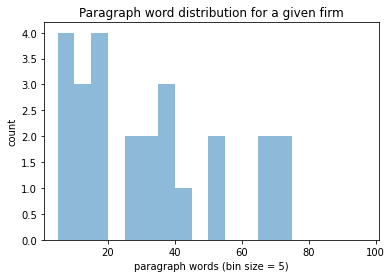

In [19]:
pp = pprint.PrettyPrinter()
# pp.pprint (documents_dict['22nd Century Limited.txt'])
# pp.pprint (all_docs_dict['22nd Century Limited.txt'])

test_firm_texts = [i for i in all_docs_dict['ARBOR THERAPEUTICS.txt']]
lens = [len(t) for t in test_firm_texts]
pp.pprint (sorted(test_firm_texts, key=len))

bins = np.arange(0, 100, 5) # fixed bin size

plt.xlim([min(lens)-5, max(lens)+5])
plt.hist(lens, bins=bins, alpha=0.5)
plt.title('Paragraph word distribution for a given firm')
plt.xlabel('paragraph words (bin size = 5)')
plt.ylabel('count')

plt.show() # this exercise suggests removing all entries <6 words would make sense

In [21]:
SEGMENT_DIR = BASE_DATA_DIR + "orgs/segments/"

# standard firm cleaning regex
def clean_firm_name (firm):
    firm_clnd = re.sub('(\.|,| corporation| incorporated| llc| inc| international| gmbh| ltd)', '', firm, flags=re.IGNORECASE).rstrip()
    return firm_clnd

def pick_firms (firm_file, all_docs_dict):
    with open(SEGMENT_DIR + firm_file) as f:
        firms = f.readlines()
    clnd_file_names = list(map (lambda x: clean_firm_name(re.sub(r'\/', r'\|', x).rstrip('\r\n')) + '.txt', firms))
    segment_dict = {}
    for name in clnd_file_names:
        if name in all_docs_dict:
            segment_dict[name] = all_docs_dict[name]
        else: 
            pass 
            # print ("Cannot find " + name)
    return segment_dict

In [22]:
# create different training sets by industry
green_firms_file = "green_small_firms.csv"
synbio_firms_file = "synbio_small_firms.csv"
nano_firms_file = "nano_small_firms.csv"

green_docs_dict= pick_firms(green_firms_file, documents_dict)
green_train, green_test, green_docs = process_doc_list(green_docs_dict)

synbio_docs_dict= pick_firms(synbio_firms_file, documents_dict)
synbio_train, synbio_test, synbio_docs = process_doc_list(synbio_docs_dict)

nano_docs_dict= pick_firms(nano_firms_file, documents_dict)
nano_train, nano_test, nano_docs = process_doc_list(nano_docs_dict)

Working on 18 firm documents
Working on 13 firm documents
Working on 23 firm documents


In [23]:
# train on all docs or a subset
all_train_test = all_train + all_test
synbio_train_test = synbio_train + synbio_test
nano_train_test = nano_train + nano_test 
green_train_test = green_train + green_test

## Run Topic Modelling

In [26]:
def topic_model(train, test, topics):
    '''
    input: preprocessed test and training data, optionally the number of topics
    output: a fitted LDA topic model and the bow representation of test data for model evaluation
    '''
    random.seed(1)
    #create topic model on full text
    #will need to run on server when we have more data
    full_dict = corpora.Dictionary(train)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train]
    test_token = [full_dict.doc2bow(doc) for doc in test]
    lda = LdaMulticore(DT_matrix, id2word=full_dict, num_topics=topics) 
    return lda, test_token

In [27]:
k = [2, 5, 10, 15, 20, 25, 30, 40 , 50, 75, 100] # possible number of topics
def calculate_perplexities(train,test, k):
    '''
    inputs: preprocessed test and training data, a list of possible number of topics
    outputs: log perplexity and perplexity, scored on the test set
    '''
    log_perplexities = []
    perplexity = []
    for i in k:
        model, test_doc2bow = topic_model(train, test, i)
        log_p = model.log_perplexity(test_doc2bow)
        log_perplexities.append(log_p)
        perp = model.bound(test_doc2bow)
        perplexity.append(perp)
    return log_perplexities, perplexity

In [28]:
all_log_perplexities, all_perplexities = calculate_perplexities(all_train, all_test, k)

In [29]:
green_log_perplexities, green_perplexities = calculate_perplexities(green_train, green_test, k)
synbio_log_perplexities, synbio_perplexities = calculate_perplexities(synbio_train, synbio_test, k)
nano_log_perplexities,nano_perplexities= calculate_perplexities(nano_train, nano_test, k)

### Perplexity Plots for each website type

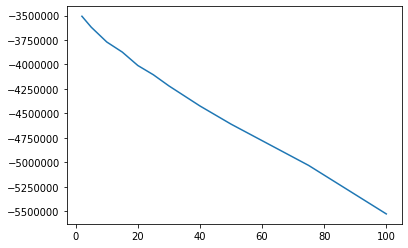

In [30]:
import matplotlib.pyplot as plt
plt.plot(k, all_perplexities)

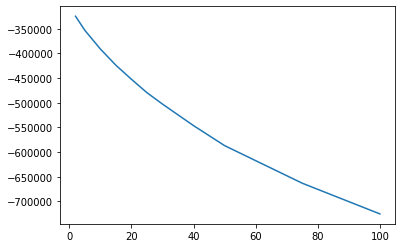

In [31]:
plt.plot(k, green_perplexities)

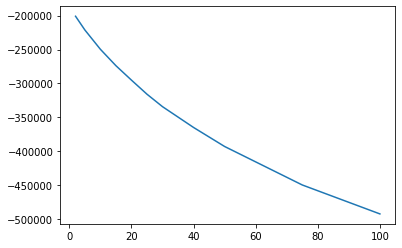

In [32]:
plt.plot(k, synbio_perplexities)

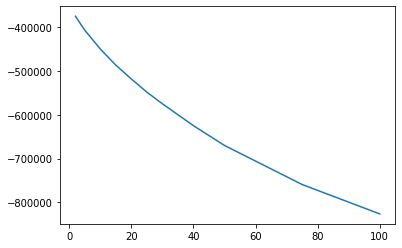

In [33]:
plt.plot(k, nano_perplexities)

### Compute coherence scores

In [34]:
# set k boundaries
limit=14; start=2; step=2

# Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (#17).
def compute_coherence_values(dictionary, corpus, texts,  start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(MALLET_PATH, corpus, id2word=dictionary, num_topics=num_topics, optimize_interval=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def visualize_coherence_values (train_test):
    full_dict = corpora.Dictionary(train_test)
    DT_matrix = [full_dict.doc2bow(doc) for doc in train_test]
    
    # Can take a long time to run
    model_list, coherence_values = compute_coherence_values(dictionary=full_dict, corpus=DT_matrix, texts=train_test, start=start, limit=limit,step=step)
    
    # Show graph
    x = list(range(start, limit, step))
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

Working on dataset: nano


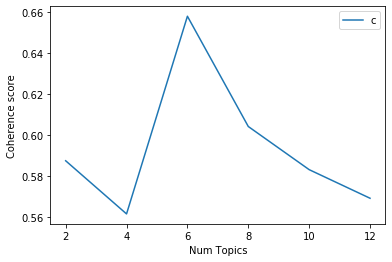

In [45]:
sector = 'nano'

datasets = { 'green': {'train_test': green_train_test,'docs': green_docs_dict},
            'nano': {'train_test': nano_train_test, 'docs': nano_docs_dict}, 
            'synbio': {'train_test': synbio_train_test, 'docs': synbio_docs_dict }}

for key, data in datasets.items():
    if key != sector:
        continue
    print ('Working on dataset: ' + key)
    visualize_coherence_values(data['train_test'])

### Predict topics by paragraph

In [46]:
# define data structs and train model
dataset = datasets[sector]['train_test']
k = 6

full_dict = corpora.Dictionary(dataset)
DT_matrix = [full_dict.doc2bow(doc) for doc in dataset]

lda_mallet = gensim.models.wrappers.LdaMallet(MALLET_PATH, corpus=DT_matrix, num_topics=k, id2word=full_dict, optimize_interval=10)

#### Visualize topics

In [47]:
lda = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet) # viz doesn't work with mallet
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, DT_matrix, full_dict)
pyLDAvis.display(LDAvis_prepared)

In [48]:
x=lda_mallet.show_topics(num_topics=k, num_words=20,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
#Below Code Prints Topics and Words
labels = []
for topic,words in topics_words:
    pp.pprint(str(topic)+ "::"+ str(words))
    labels.append('|'.join(words[0:5]))

("0::['univers', 'presid', 'serv', 'manag', 'director', 'board', 'mr.', "
 "'engin', 'develop', 'vice', 'offic', 'execut', 'year', 'dr.', 'join', "
 "'research', 'chief', 'scienc', 'prior', 'includ']")
("1::['develop', 'research', 'cancer', 'clinic', 'drug', 'diseas', 'medic', "
 "'treatment', 'patient', 'medicin', 'biolog', 'detect', 'test', 'diagnost', "
 "'cell', 'system', 'health', 'platform', 'therapi', 'therapeut']")
("2::['inform', 'ani', 'provid', 'person', 'data', 'pleas', 'servic', 'site', "
 "'includ', 'law', 'websit', 'tesla', 'contact', 'email', 'result', 'requir', "
 "'access', 'time', 'parti', 'collect']")
("3::['award', 'stori', 'amp', 'correct', 'state', 'error', '2018', 'salon', "
 "'regret', 'year', '2019', 'articl', 'confer', '2016', 'receiv', 'origin', "
 "'post', 'made', 'incorrect', 'american']")
("4::['custom', 'servic', 'manag', 'develop', 'provid', 'solut', 'innov', "
 "'work', 'cloud', 'industri', 'support', 'team', 'global', 'market', 'world', "
 "'experi', 

In [49]:
# print topic labels for import into R (note these need to be copied into R every time you train a new topic model)
print ("Copy this into R:")
labels_out = 'c("start|state","' + '", "'.join(labels) + '")'

print (labels_out)
labels_file = BASE_DATA_DIR + '/orgs/para_topics_panel/' + sector + '_labels.txt' # where output files are stored
if os.path.isfile(labels_file):
    os.remove(labels_file)
    
with open(labels_file, 'a') as lf:
    lf.write(labels_out)

Copy this into R:
c("start|state","univers|presid|serv|manag|director", "develop|research|cancer|clinic|drug", "inform|ani|provid|person|data", "award|stori|amp|correct|state", "custom|servic|manag|develop|provid", "system|develop|manufactur|materi|design")


#### Create output data structure and write to file

In [50]:
# test topic inference and top topic extract in lda mallet
para_topic_2 = 'power develop energy provide service market custom system'
para_topic_3 = 'manage universal director president board leadership phd doctor'

topic_by_prob = sorted([(i[1],i[0]) for i in lda_mallet[full_dict.doc2bow(utils.simple_preprocess(para_topic_3))]], reverse = True)
pp.pprint(topic_by_prob)

print(topic_by_prob[0][1])
print(topic_by_prob[0][0])

[(0.8796323743972226, 0),
 (0.033211540185033306, 2),
 (0.029996099721394047, 4),
 (0.02802927933820974, 1),
 (0.018690079304449974, 5),
 (0.010440627053690319, 3)]
0
0.8796323743972226


In [ ]:
topic_by_firm_vector = {} # at the firm level

# create output data structure
for firm_key in datasets[sector]['docs']: # or nano_docs or synbio_docs
    firm_paras = all_docs_dict[firm_key]
    print ('Working on ' + firm_key + ' with ' + str(len(firm_paras)) + ' paragraphs.')
    main_topic = [] # at the firm level, where each para is an entry
    main_topic_probs = [] # same, but for probabilities
    para_order = []
    para_len = [] 
    order_num = 0

    # start state
    main_topic.append(-1)
    main_topic_probs.append(1)
    para_order.append(order_num)
    order_num += 1
    para_len.append(0)
    
    for para in firm_paras:
        para_len.append(len(para))
        topic_by_prob = sorted([(i[1],i[0]) for i in lda_mallet[full_dict.doc2bow(para)]], reverse = True)
        main_topic.append(topic_by_prob[0][1])
        main_topic_probs.append(topic_by_prob[0][0])
        para_order.append(order_num)
        order_num += 1

    firm_df = pd.DataFrame(
        {'firm': re.sub('\|', '/', firm_key.split('.')[0]), 
         'para_order': para_order,
         'num_words': para_len,
         'main_topic': main_topic,
         'prob': main_topic_probs
        })
    topic_by_firm_vector[firm_key] = firm_df # set at the firm level 

Working on ACACIA RESEARCH GROUP.txt with 33 paragraphs.
Working on NanoOncology.txt with 49 paragraphs.
Working on Immunolight.txt with 64 paragraphs.
Working on Kinetech Power Company.txt with 13 paragraphs.
Working on Lux Bio Group.txt with 4 paragraphs.
Working on Magnolia Solar.txt with 80 paragraphs.
Working on Mattson Technology.txt with 74 paragraphs.
Working on The Paymaster.txt with 34 paragraphs.
Working on PortaFire.txt with 1 paragraphs.
Working on Soliton Lasers.txt with 26 paragraphs.
Working on S&S X-Ray Products.txt with 11 paragraphs.
Working on True-Safe Technologies.txt with 21 paragraphs.
Working on VERLASE TECHNOLOGIES.txt with 2 paragraphs.
Working on Crystal Solar.txt with 6 paragraphs.
Working on SII Semiconductor.txt with 74 paragraphs.
Working on Alliance for Sustainable Energy.txt with 5 paragraphs.
Working on Arkival Technology Corp.txt with 4 paragraphs.
Working on Coactive Drive.txt with 18 paragraphs.
Working on FRONT EDGE TECHNOLOGY.txt with 2 paragraph

In [ ]:
# Test output for a given firm 
print ('Found output for ' + str(len(topic_by_firm_vector.keys())) + ' firms.  Here is an example:')
pp = pprint.PrettyPrinter()
pp.pprint (documents_dict['US NUTRACEUTICALS.txt'])
pp.pprint (all_docs_dict['US NUTRACEUTICALS.txt'])
print(topic_by_firm_vector['US NUTRACEUTICALS.txt'])